In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Part 2 (Data Preparation)

## Female Births Dataset (Parsing Time)

In [2]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from pylab import rcParams


# header=0: We must specify the header information at row 0.
# parse dates=True: We give the function a hint that data in the first column contains dates that need to be parsed.
# index col=0: We hint that the first column contains the index information for the time series.
# squeeze=True: We hint that we only have one data column and that we are interested in a Series and not a DataFrame.


# In most cases this should work without the need to use a date parser
series = pd.read_csv('/content/drive/MyDrive/ANONYMOUS MORHF/Cycle 1 (Traditional TS)/Hamamsy/daily-total-female-births.csv', header=0, index_col=0, parse_dates=True,
squeeze=True)
print(type(series))
print(series.head())

<class 'pandas.core.series.Series'>
date
1959-01-01    35
1959-01-02    32
1959-01-03    30
1959-01-04    31
1959-01-05    44
Name: births, dtype: int64


In [3]:
from datetime import datetime

# This is another way to read the time in pandas by defining a lambda function to do so
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')
series = pd.read_csv('/content/drive/MyDrive/ANONYMOUS MORHF/Cycle 1 (Traditional TS)/Hamamsy/daily-total-female-births.csv', header=0, index_col=0, parse_dates=True,
squeeze=True,date_parser=dateparse)
print(type(series))
print(series.head())

<class 'pandas.core.series.Series'>
date
1959-01-01    35
1959-01-02    32
1959-01-03    30
1959-01-04    31
1959-01-05    44
Name: births, dtype: int64


In [4]:
print(series.size)

365


In [5]:
# You can slice, dice, and query your series using the time index. For example, you can access all
# observations in January as follows:
print(series['1959-01'])
print('')

# From to
print(series['1959-01-02':'1959-01-10'])
print('')

# Select some
print(series[['1959-01-02','1959-01-10']])

date
1959-01-01    35
1959-01-02    32
1959-01-03    30
1959-01-04    31
1959-01-05    44
1959-01-06    29
1959-01-07    45
1959-01-08    43
1959-01-09    38
1959-01-10    27
1959-01-11    38
1959-01-12    33
1959-01-13    55
1959-01-14    47
1959-01-15    45
1959-01-16    37
1959-01-17    50
1959-01-18    43
1959-01-19    41
1959-01-20    52
1959-01-21    34
1959-01-22    53
1959-01-23    39
1959-01-24    32
1959-01-25    37
1959-01-26    43
1959-01-27    39
1959-01-28    35
1959-01-29    44
1959-01-30    38
1959-01-31    24
Name: births, dtype: int64

date
1959-01-02    32
1959-01-03    30
1959-01-04    31
1959-01-05    44
1959-01-06    29
1959-01-07    45
1959-01-08    43
1959-01-09    38
1959-01-10    27
Name: births, dtype: int64

date
1959-01-02    32
1959-01-10    27
Name: births, dtype: int64


In [6]:
# 7 number description
print(series.describe())

count    365.000000
mean      41.980822
std        7.348257
min       23.000000
25%       37.000000
50%       42.000000
75%       46.000000
max       73.000000
Name: births, dtype: float64


## Daily min temperatures (Sliding Windows and Expanding)

In [7]:
# Here we faced a problem with chunk size as it returned a text reader object to skip last lines we use skipfooter and specify how many rows to skip
# engine = 'python' as skip footer will use the python engine instead of the c engine
series = pd.read_csv('/content/drive/MyDrive/ANONYMOUS MORHF/Cycle 1 (Traditional TS)/Hamamsy/daily-minimum-temperatures.csv', header=0, index_col=0,
parse_dates=True, squeeze=True, skipfooter=2, engine='python')

# To clean data from unexpected characters 
def rem_chars(str):
  return float(''.join([x for x in str if x.isnumeric() or x == '.']))

# Cleaning the series permanently
series = series.apply(rem_chars)


dataframe = pd.DataFrame()
dataframe['month'] = series.index.month
dataframe['day'] = series.index.day
dataframe['temperature'] = series.values

print('Extracting month and day as datetime based engineered features:\n')
print(dataframe.head(5))

Extracting month and day as datetime based engineered features:

   month  day  temperature
0      1    1         20.7
1      1    2         17.9
2      1    3         18.8
3      1    4         14.6
4      1    5         15.8


In [8]:
# Lagged Features using the shift method and then concating the results, sliding window = 1

print('Lagged Features using the shift method and then concating the results:\nSliding window = 1\n')
temps = pd.DataFrame(series.values)
dataframe = pd.concat([temps.shift(1), temps], axis=1)
dataframe.columns = ['t', 't+1']
print(dataframe.head(5))

Lagged Features using the shift method and then concating the results:
Sliding window = 1

      t   t+1
0   NaN  20.7
1  20.7  17.9
2  17.9  18.8
3  18.8  14.6
4  14.6  15.8


In [9]:
# Lagged Features using the shift method and then concating the results, sliding window = 1

print('Lagged Features using the shift method and then concating the results:\nSliding window = 3\n')
temps = pd.DataFrame(series.values)
dataframe = pd.concat([temps.shift(3), temps.shift(2), temps.shift(1), temps], axis=1)
dataframe.columns = ['t-2', 't-1', 't', 't+1']
print(dataframe.head(5))

Lagged Features using the shift method and then concating the results:
Sliding window = 3

    t-2   t-1     t   t+1
0   NaN   NaN   NaN  20.7
1   NaN   NaN  20.7  17.9
2   NaN  20.7  17.9  18.8
3  20.7  17.9  18.8  14.6
4  17.9  18.8  14.6  15.8


In [10]:
# Getting the rolling mean with window = 2
print('Getting the rolling mean with window = 2:\n')
temps = pd.DataFrame(series.values)
shifted = temps.shift(1)
window = shifted.rolling(window=2)
means = window.mean()
dataframe = pd.concat([means, temps], axis=1)
dataframe.columns = ['mean(t-1,t)', 't+1']
print(dataframe.head(5))

Getting the rolling mean with window = 2:

   mean(t-1,t)   t+1
0          NaN  20.7
1          NaN  17.9
2        19.30  18.8
3        18.35  14.6
4        16.70  15.8


In [11]:
# Getting some rolling summary statistics with window = 3
temps = pd.DataFrame(series.values)
width = 4
shifted = temps.shift(width - 1)
window = shifted.rolling(window=width)
dataframe = pd.concat([window.min(), window.mean(), window.max(), temps], axis=1)
dataframe.columns = ['min', 'mean', 'max', 't+1']
print(dataframe.head(7))

    min  mean   max   t+1
0   NaN   NaN   NaN  20.7
1   NaN   NaN   NaN  17.9
2   NaN   NaN   NaN  18.8
3   NaN   NaN   NaN  14.6
4   NaN   NaN   NaN  15.8
5   NaN   NaN   NaN  15.8
6  14.6  18.0  20.7  15.8


In [12]:
# The expanding function is similar to a sliding window but the window size increases by 1 in each row
# We shift the temps variable to use as a target variable.
temps = pd.DataFrame(series.values)
window = temps.expanding()
dataframe = pd.concat([window.min(), window.mean(), window.max(), temps.shift(-1)], axis=1)
dataframe.columns = ['min', 'mean', 'max', 't+1']
print(dataframe.head(5))

    min       mean   max   t+1
0  20.7  20.700000  20.7  17.9
1  17.9  19.300000  20.7  18.8
2  17.9  19.133333  20.7  14.6
3  14.6  18.000000  20.7  15.8
4  14.6  17.560000  20.7  15.8


## Visualization

* Line Plots.
* Histograms and Density Plots.
* Box and Whisker Plots.
* Heat Maps.
* Lag Plots or Scatter Plots.
* Autocorrelation Plots.


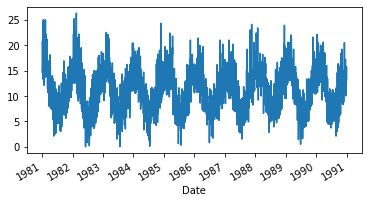

In [13]:
# line plots
import matplotlib.pyplot as plt
rcParams['figure.figsize'] = 6, 3

series.plot()
plt.show()

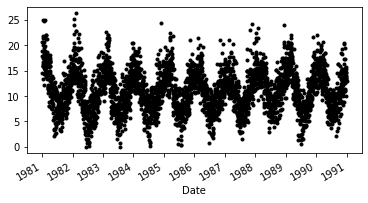

In [14]:
# Modifying the style a little bit
# rcParams['figure.figsize'] = 10, 10

series.plot(style='k.')
plt.show()

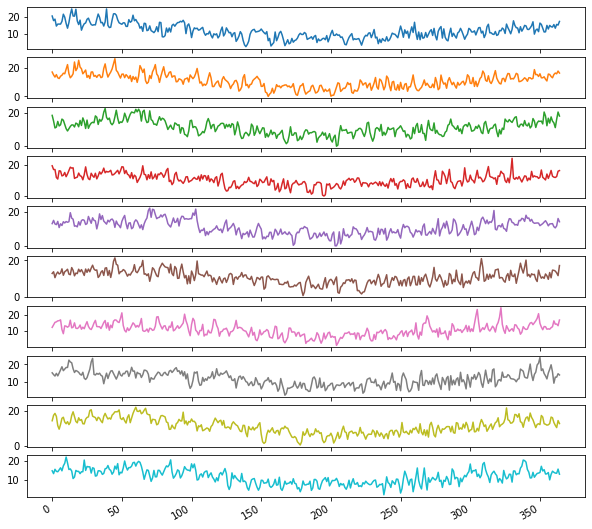

In [15]:
# grouping data by year and create a line plot for each year for direct comparison.
rcParams['figure.figsize'] = 10, 10


groups = series.groupby(pd.Grouper(freq='A'))
years = pd.DataFrame()
for name, group in groups:
  years[name.year] = group.values
years.plot(subplots=True, legend=False)
plt.show()

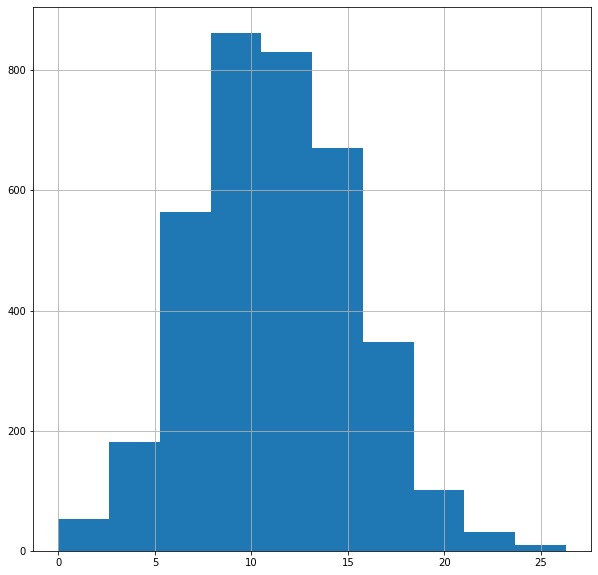

In [16]:
# Some linear time series forecasting methods assume a well-behaved distribution of observations (i.e. a bell curve or normal distribution).
# This discards the temporal information

series.hist()
plt.show()

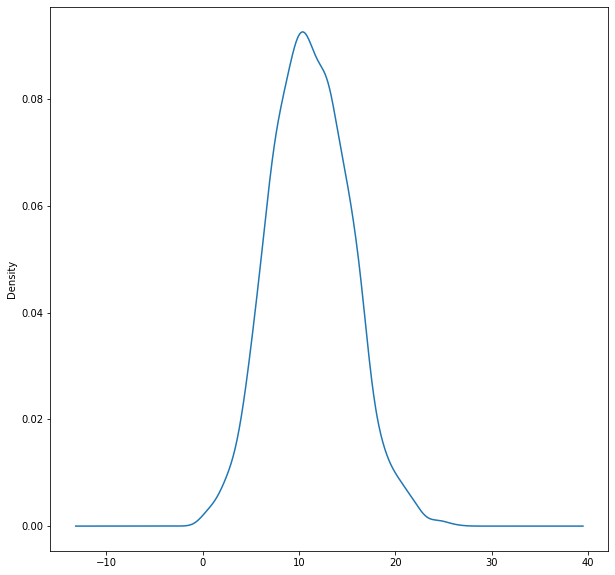

In [17]:
# Working with density plot only 
# The density function uses the data points and estimates a probability function for them 

series.plot(kind='kde')
plt.show()

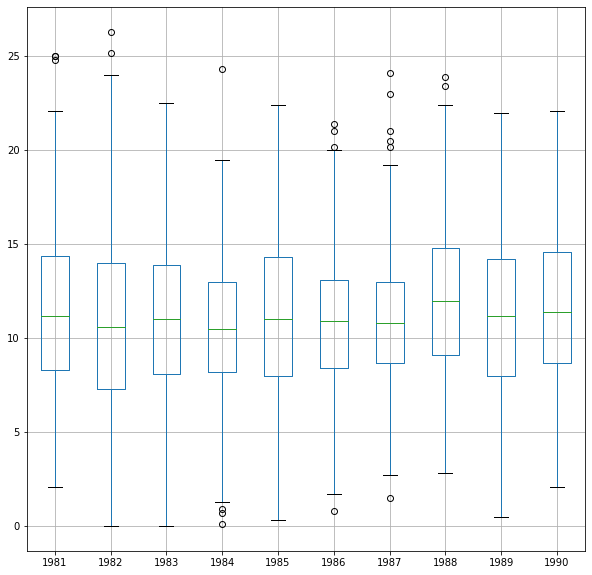

In [18]:
# Box plot to spot outliers, seasonality, and trend across grouped by periods (years in this case).

# freq = 'A' specifies that the groups should be years from the start of the year to the end for other freqs:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
groups = series.groupby(pd.Grouper(freq='A'))
years = pd.DataFrame()
for name, group in groups:
  years[name.year] = group.values
years.boxplot()
plt.show()

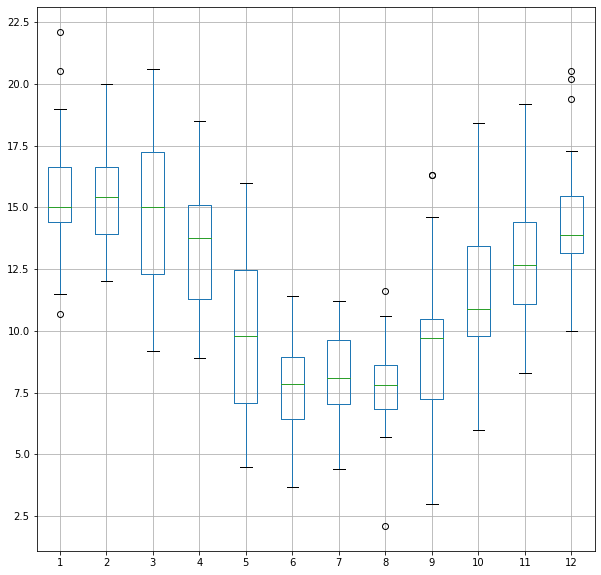

In [19]:
# We may also be interested in the distribution of values across months within a year.


one_year = series['1990']
groups = one_year.groupby(pd.Grouper(freq='M'))
months = pd.concat([pd.DataFrame(x[1].values) for x in groups], axis=1)
months = pd.DataFrame(months)
months.columns = range(1,13)
months.boxplot()
_ = plt.show()

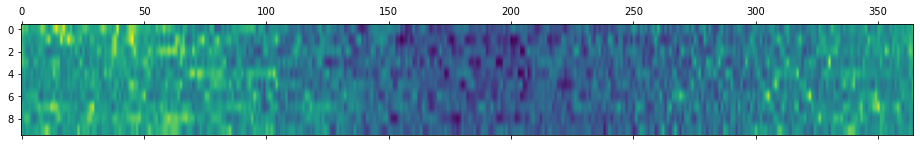

In [20]:
# Heatmap

groups = series.groupby(pd.Grouper(freq='A'))
years = pd.DataFrame()
for name, group in groups:
  years[name.year] = group.values
years = years.T
plt.matshow(years, interpolation=None, aspect='auto')
plt.show()

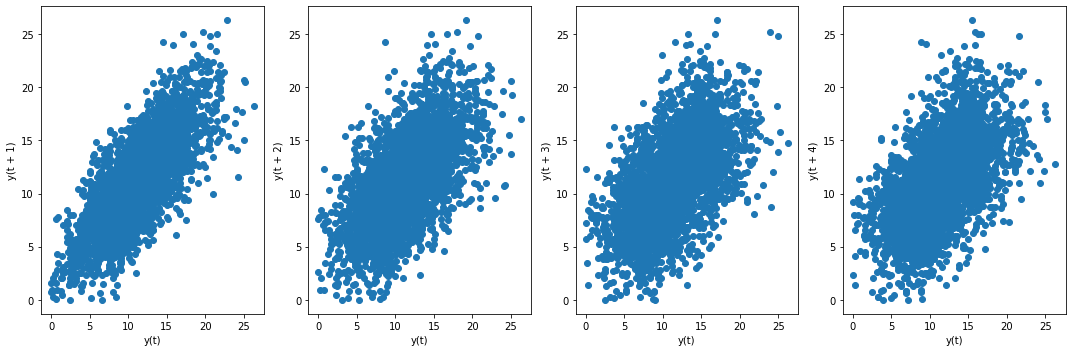

In [21]:
# Lag plot shows the relationship between the obs at time t and their lag(k)
from pandas.plotting import lag_plot
import matplotlib as mpl
# mpl.rcParams.update(mpl.rcParamsDefault)

rcParams['figure.figsize'] = 15,5

k = 4

for i in range(1,k+1):
  plt.subplot(1, k, i)
  lag_plot(series, lag = i)

plt.tight_layout()
plt.show()


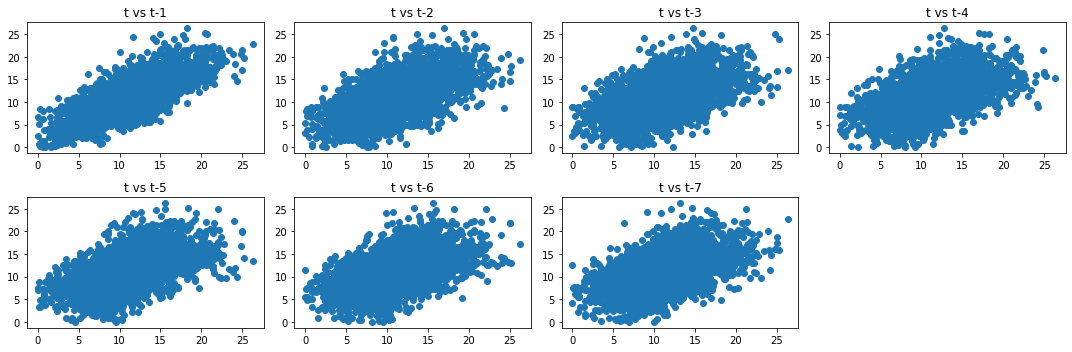

In [22]:
# Multible Lags

values = pd.DataFrame(series.values)
lags = 7
columns = [values]

for i in range(1,(lags + 1)):
  columns.append(values.shift(i))
dataframe = pd.concat(columns, axis=1)
columns = ['t']

for i in range(1,(lags + 1)):
  columns.append('t-' + str(i))
dataframe.columns = columns
plt.figure(1)

for i in range(1,(lags + 1)):
  ax = plt.subplot(240 + i)
  ax.set_title('t vs t-' + str(i))
  plt.scatter(x=dataframe['t'].values, y=dataframe['t-'+str(i)].values)

plt.tight_layout()
plt.show()

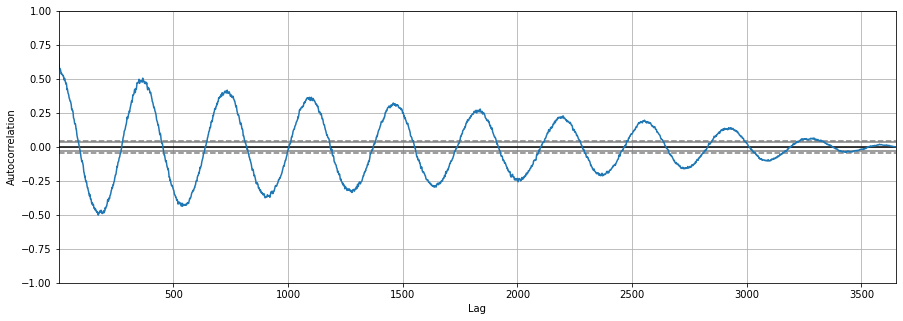

In [23]:
# Auto-correlation plot
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(series)
plt.show()

## Shampoo sales dataset (Resampling)

In [24]:
from pandas import datetime

# The date here is specified in the form of 1-01 to indicate jan, first year, we used a baseline of 1900 to convert it to datetime format (it can be any year)
# def parser(x):
#   return datetime.strptime('190'+x, '%Y-%m')
parser = lambda x: datetime.strptime('190'+x, '%Y-%m')

series = pd.read_csv('/content/drive/MyDrive/ANONYMOUS MORHF/Cycle 1 (Traditional TS)/Hamamsy/shampoo_sales.csv', header=0, index_col=0, parse_dates=True,
squeeze=True, date_parser=parser)

print('Original Series:\n')
print(series.head(),'\n\n')

# Upsampling generate dates with the specified period for example 1D means one day apart, 5D: 5 days apart and so on
# We then need an interpolation function to fill the missing the values 
# 1M: 1 month, 1Q: 1 quearter, and 1Y: 1 year but then we will need to specify the aggregation function as we are downsampling
print('Upsampled Series:\n')
upsampled = series.resample('1D').mean()
print(upsampled.head(32))

Original Series:

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales, dtype: float64 


Upsampled Series:

Month
1901-01-01    266.0
1901-01-02      NaN
1901-01-03      NaN
1901-01-04      NaN
1901-01-05      NaN
1901-01-06      NaN
1901-01-07      NaN
1901-01-08      NaN
1901-01-09      NaN
1901-01-10      NaN
1901-01-11      NaN
1901-01-12      NaN
1901-01-13      NaN
1901-01-14      NaN
1901-01-15      NaN
1901-01-16      NaN
1901-01-17      NaN
1901-01-18      NaN
1901-01-19      NaN
1901-01-20      NaN
1901-01-21      NaN
1901-01-22      NaN
1901-01-23      NaN
1901-01-24      NaN
1901-01-25      NaN
1901-01-26      NaN
1901-01-27      NaN
1901-01-28      NaN
1901-01-29      NaN
1901-01-30      NaN
1901-01-31      NaN
1901-02-01    145.9
Freq: D, Name: Sales, dtype: float64


Month
1901-01-01    266.000000
1901-01-02    262.125806
1901-01-03    258.251613
1901-01-04    254.377419
1901-01-05    250.503226
1901-01-06    246.629032
1901-01-07    242.754839
1901-01-08    238.880645
1901-01-09    235.006452
1901-01-10    231.132258
1901-01-11    227.258065
1901-01-12    223.383871
1901-01-13    219.509677
1901-01-14    215.635484
1901-01-15    211.761290
1901-01-16    207.887097
1901-01-17    204.012903
1901-01-18    200.138710
1901-01-19    196.264516
1901-01-20    192.390323
1901-01-21    188.516129
1901-01-22    184.641935
1901-01-23    180.767742
1901-01-24    176.893548
1901-01-25    173.019355
1901-01-26    169.145161
1901-01-27    165.270968
1901-01-28    161.396774
1901-01-29    157.522581
1901-01-30    153.648387
1901-01-31    149.774194
1901-02-01    145.900000
Freq: D, Name: Sales, dtype: float64


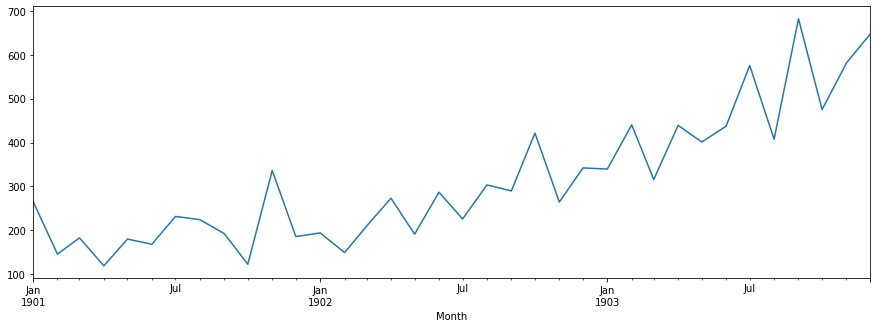

In [25]:
# You can see that there's a line between the two known values at the start of each month
upsampled = series.resample('D').mean() # The agg function here does nothing as we are upsampling when downsampling the function used is important
interpolated = upsampled.interpolate(method='linear')
print(interpolated.head(32))
interpolated.plot()
plt.show()


# ‘time’: Works on daily and higher resolution data to interpolate given length of interval.
# time would be useful if the indecis (dates) were not equally spaced but since they are equally spaced it works the same as linear.
# Other interpolation methods are found in pandas documentary

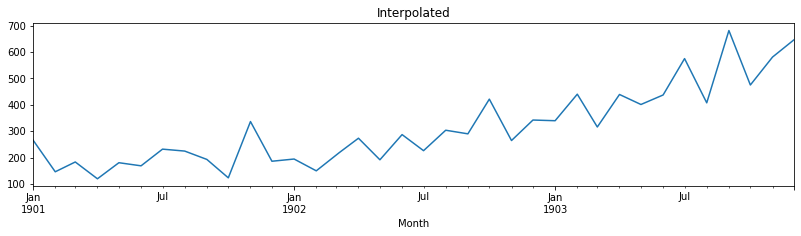

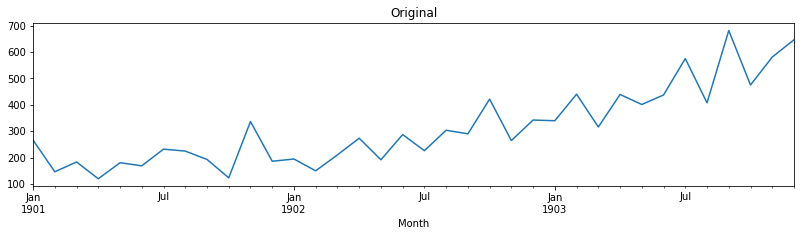

In [26]:
rcParams['figure.figsize'] = 30, 3
# Interpolated
plt.subplot(1,2,1)
interpolated.plot()
plt.title('Interpolated')
plt.show()

print('')

# Original
plt.subplot(1,2,2)
series.plot()
plt.title('Original')
plt.show()

# we can see that there is no difference between the plots as linear interpolation is used, however the granualarity is different

Month
1901-01-01    266.000000
1901-01-02    258.630160
1901-01-03    251.560886
1901-01-04    244.720748
1901-01-05    238.109746
1901-01-06    231.727880
1901-01-07    225.575149
1901-01-08    219.651553
1901-01-09    213.957094
1901-01-10    208.491770
1901-01-11    203.255582
1901-01-12    198.248529
1901-01-13    193.470612
1901-01-14    188.921831
1901-01-15    184.602185
1901-01-16    180.511676
1901-01-17    176.650301
1901-01-18    173.018063
1901-01-19    169.614960
1901-01-20    166.440993
1901-01-21    163.496161
1901-01-22    160.780465
1901-01-23    158.293905
1901-01-24    156.036481
1901-01-25    154.008192
1901-01-26    152.209039
1901-01-27    150.639021
1901-01-28    149.298139
1901-01-29    148.186393
1901-01-30    147.303783
1901-01-31    146.650308
1901-02-01    145.900000
Freq: D, Name: Sales, dtype: float64


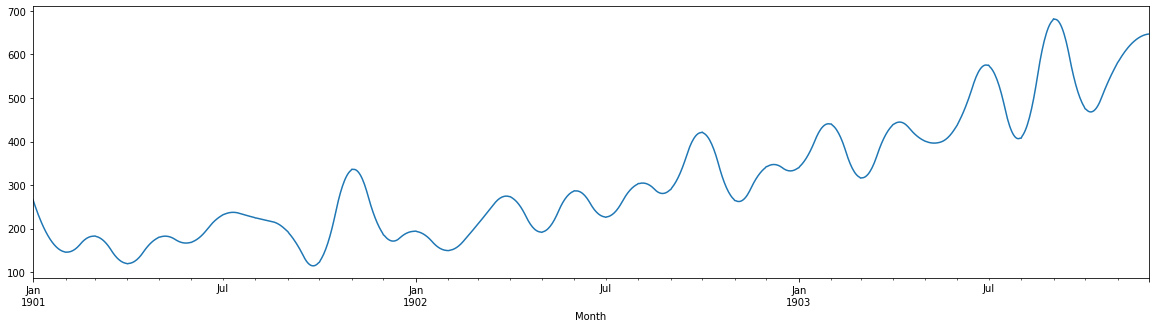

In [27]:
# Another common interpolation method is to use a polynomial or a spline to connect the values. And specify the order
# Spline interpolation and polynomial interpolationin general:
# https://towardsdatascience.com/polynomial-interpolation-3463ea4b63dd
rcParams['figure.figsize'] = 20, 5
upsampled = series.resample('D').mean()
interpolated = upsampled.interpolate(method='spline', order=2)
print(interpolated.head(32))
interpolated.plot()
plt.show()

Month
1901-03-31    198.333333
1901-06-30    156.033333
1901-09-30    216.366667
1901-12-31    215.100000
1902-03-31    184.633333
Freq: Q-DEC, Name: Sales, dtype: float64


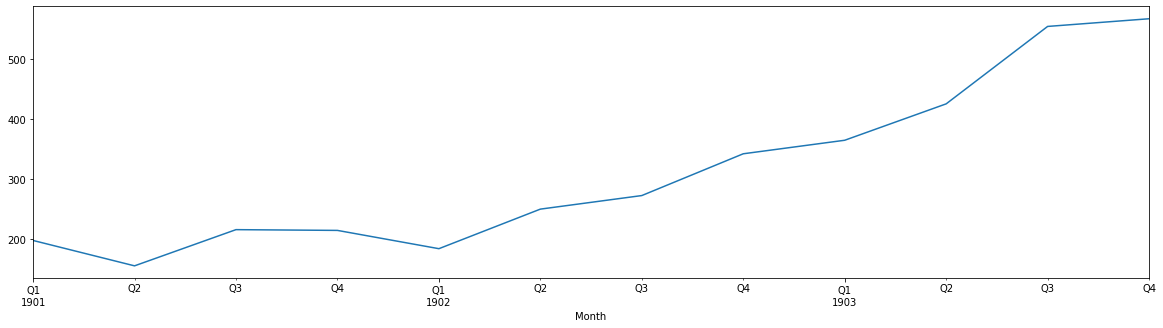

In [28]:
# Downsampling to quarters
resample = series.resample('Q')
quarterly_mean_sales = resample.mean() # Here the aggregation function aggregates the values at each quarter
print(quarterly_mean_sales.head())
quarterly_mean_sales.plot()
plt.show()


In [29]:
# Say we started from series['1901-05-01':]
# the downsampled series would start from 1901-06-30 (the following business quarter); it will discard previous vals as they do not constitute a whole quarter
resample = series['1901-05-01':].resample('Q')
quarterly_mean_sales = resample.mean() # Here the aggregation function aggregates the values at each quarter
print(quarterly_mean_sales.head())

Month
1901-06-30    174.400000
1901-09-30    216.366667
1901-12-31    215.100000
1902-03-31    184.633333
1902-06-30    250.566667
Freq: Q-DEC, Name: Sales, dtype: float64


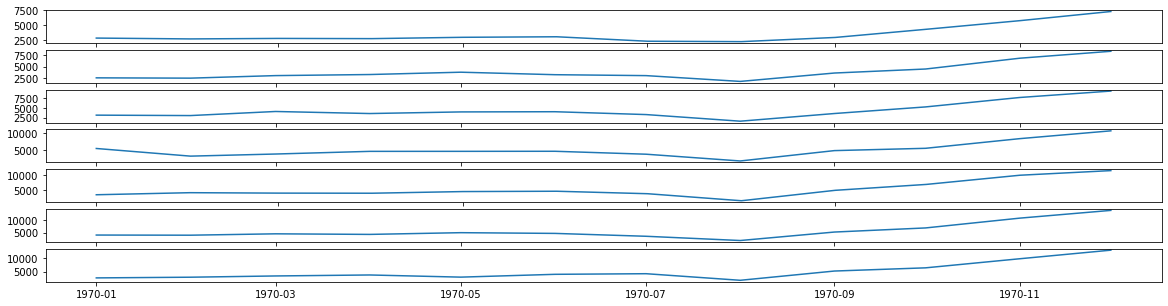

In [30]:
# Line plot for each year to confirm seasonality
series = pd.read_csv('/content/drive/MyDrive/ANONYMOUS MORHF/Cycle 1 (Traditional TS)/Hamamsy/monthly-champagne.csv', header=0, index_col=0, parse_dates=True,
squeeze=True,skipfooter=2, engine='python')


groups = series['1964':'1970'].groupby(pd.Grouper(freq='A'))
years = pd.DataFrame()
plt.figure()
i = 1
n_groups = len(groups)
for name, group in groups:
  plt.subplot((n_groups*100) + 10 + i)
  i += 1
  plt.plot(group)
plt.show()

In [31]:
series

Month
1964-01-01    2815
1964-02-01    2672
1964-03-01    2755
1964-04-01    2721
1964-05-01    2946
              ... 
1972-05-01    4618
1972-06-01    5312
1972-07-01    4298
1972-08-01    1413
1972-09-01    5877
Name: Perrin Freres monthly champagne sales millions ?64-?72, Length: 105, dtype: int64

## AirPassengers Dataset (Power transforms)

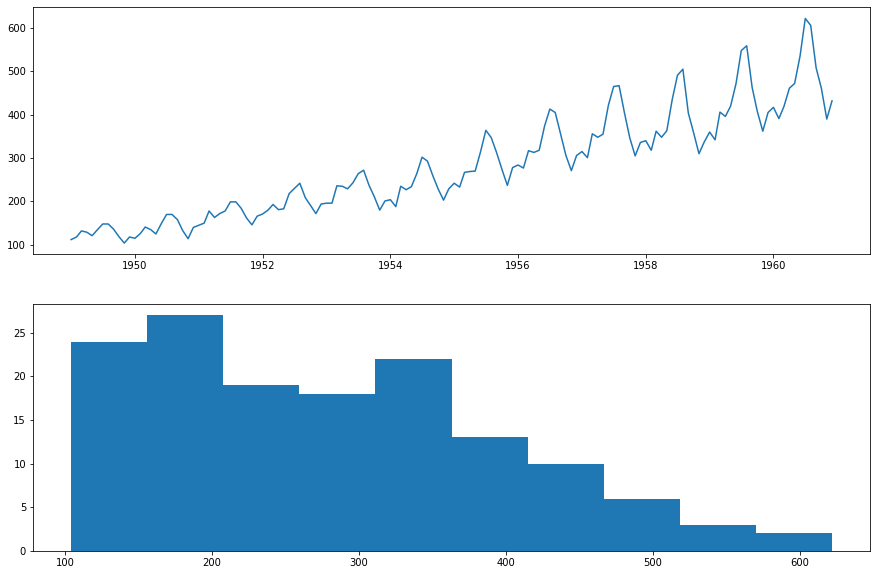

In [32]:
series = pd.read_csv('/content/drive/MyDrive/ANONYMOUS MORHF/Cycle 1 (Traditional TS)/Hamamsy/AirPassengers.csv'
, header=0, index_col=0, parse_dates=True, squeeze=True
)

rcParams['figure.figsize'] = 15, 10
plt.figure(1)
# line plot
plt.subplot(211)
plt.plot(series)
# histogram 
plt.subplot(212)
plt.hist(series)
plt.show()

# We can see that the distribution of the data is not normal

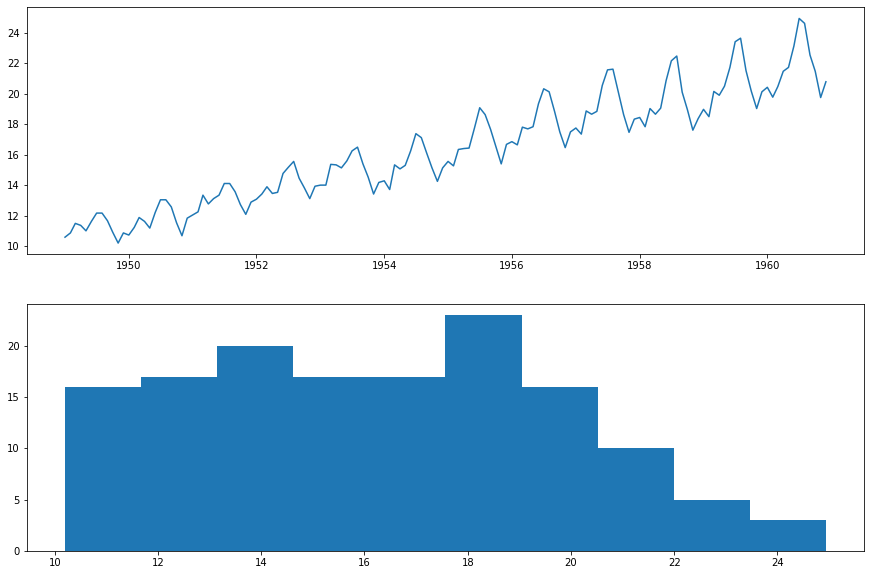

In [33]:
# Sqrt transformation
series_sqrted = np.sqrt(series)

rcParams['figure.figsize'] = 15, 10
plt.figure(1)
# line plot
plt.subplot(211)
plt.plot(series_sqrted)
# histogram 
plt.subplot(212)
plt.hist(series_sqrted)
plt.show()


# The increase of variance over time, though less, is still there. Also, the distribution still shows a long tail.
# This indicates that the increase over time is probably not quadratic 

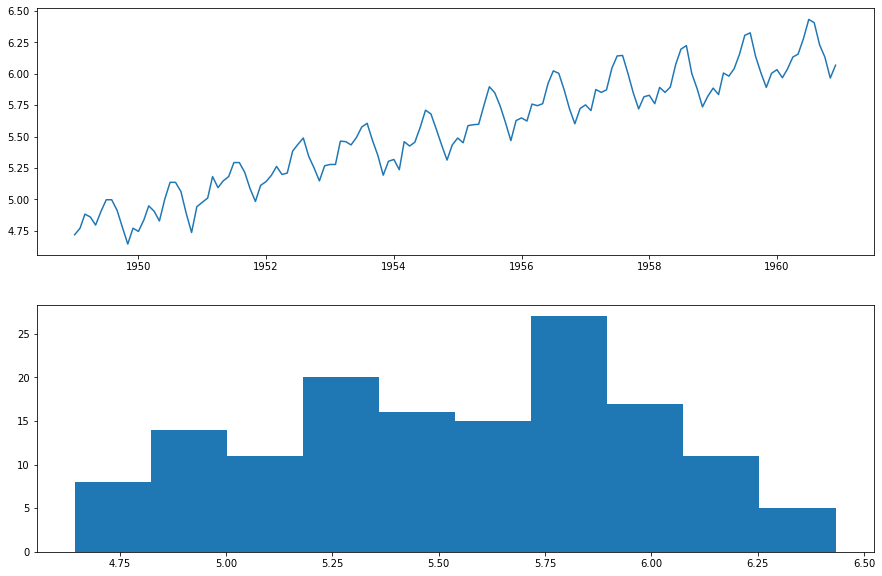

In [34]:
# Log Transformation
series_logged = np.log(series+0.01) # base: e, add constant to avoid zero values issue

rcParams['figure.figsize'] = 15, 10
plt.figure(1)
# line plot
plt.subplot(211)
plt.plot(series_logged)
# histogram 
plt.subplot(212)
plt.hist(series_logged)
plt.show()

# The increase of variance over time is no longer significant, also, the distribution is approxamtely symmetric with no long tails.

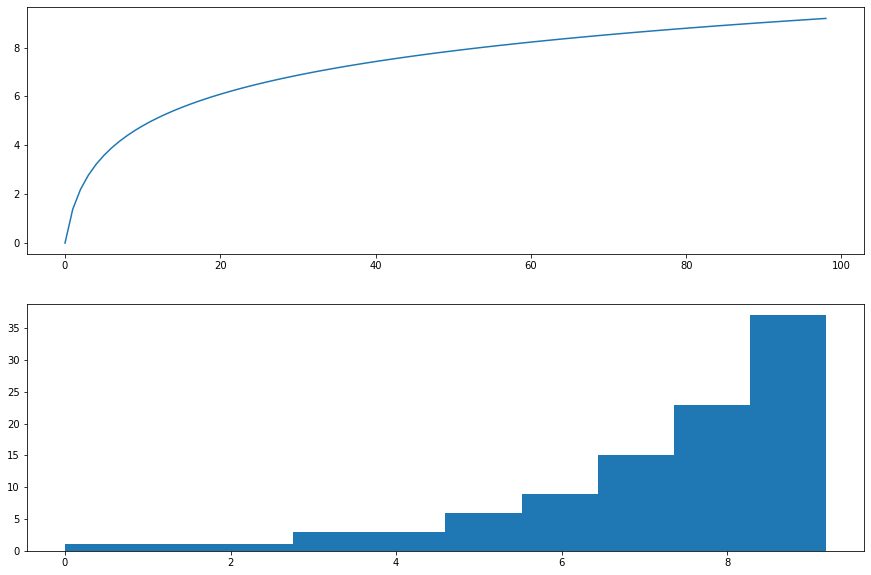

In [35]:
# This is an example to show that using a log transform for data with quadratic trend will not transform it into a linear trend, thus appropriate transforms should be used
# We can start by sqrt transform, if not solved move to log transform.

trial = [i**2 for i in range(1,100)]
# sqrt transform
transform = np.log(trial)
plt.figure(1)
# line plot
plt.subplot(211)
plt.plot(transform)
# histogram
plt.subplot(212)
plt.hist(transform)
plt.show()

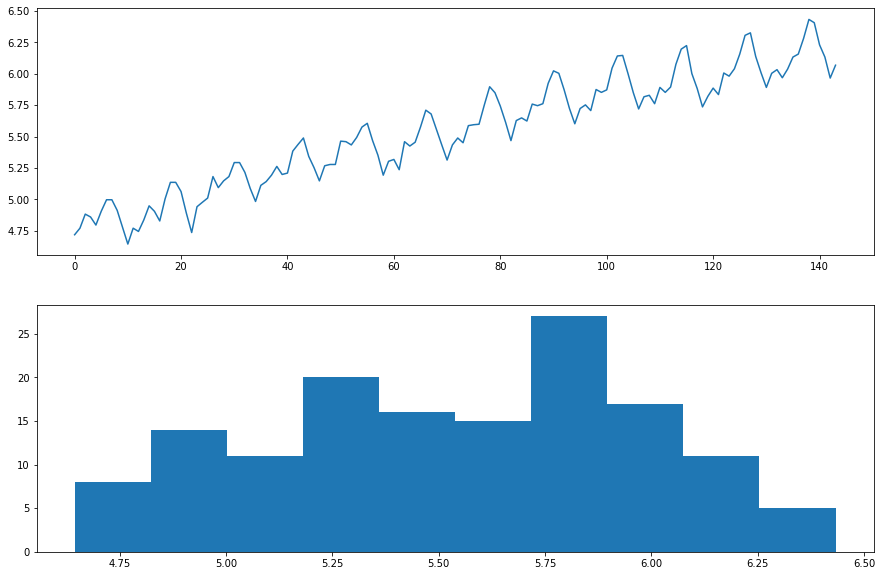

In [36]:
# Box Cox transform:
from scipy.stats import boxcox

series_logged = boxcox(series+0.01, lmbda=0.0) # lambda=0.0 (log), add constant to avoid zero values issue

rcParams['figure.figsize'] = 15, 10
plt.figure(1)
# line plot
plt.subplot(211)
plt.plot(series_logged)
# histogram 
plt.subplot(212)
plt.hist(series_logged)
plt.show()

Lambda value:  0.147995014882878 



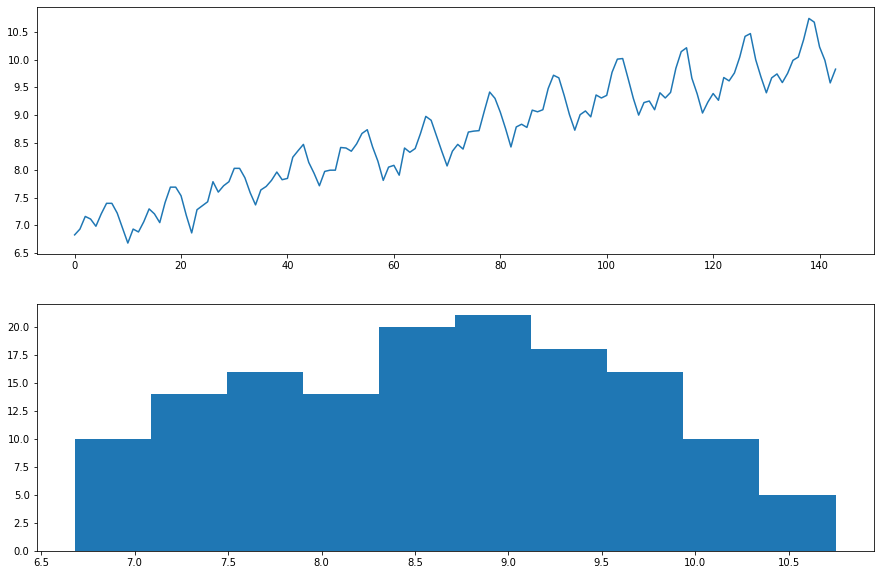

In [37]:
#
#
#
#
#
# Most Useful
# A wonderful trick to use lambda = None, this lets the algorithm decide on the value of lambda to be used
from scipy.stats import boxcox

series_logged, lamda = boxcox(series+0.01, lmbda=None) # lambda=0.0 (log), add constant to avoid zero values issue

print('Lambda value: ',lamda, '\n')

rcParams['figure.figsize'] = 15, 10
plt.figure(1)
# line plot
plt.subplot(211)
plt.plot(series_logged)
# histogram 
plt.subplot(212)
plt.hist(series_logged)
plt.show()



## Smoothing

date
1959-01-01          NaN
1959-01-02          NaN
1959-01-03    32.333333
1959-01-04    31.000000
1959-01-05    35.000000
1959-01-06    34.666667
1959-01-07    39.333333
1959-01-08    39.000000
1959-01-09    42.000000
1959-01-10    36.000000
Name: births, dtype: float64


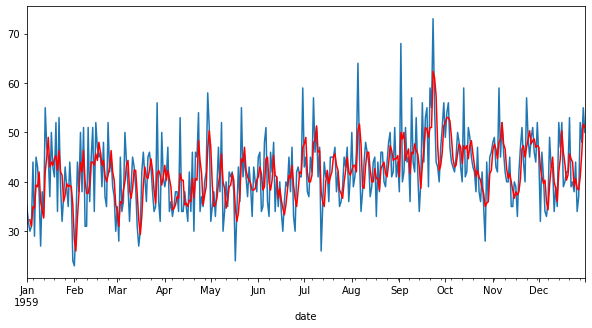

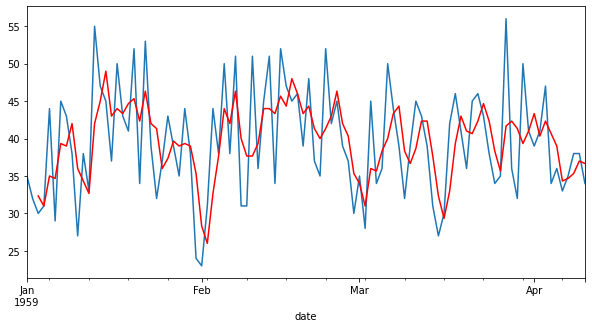

In [38]:
# Trailing moving average

series = pd.read_csv('/content/drive/MyDrive/ANONYMOUS MORHF/Cycle 1 (Traditional TS)/Hamamsy/daily-total-female-births.csv', header=0, index_col=0, parse_dates=True,
squeeze=True)


rcParams['figure.figsize'] = 10, 5
# tail-rolling average transform
rolling = series.rolling(window=3)
rolling_mean = rolling.mean()
print(rolling_mean.head(10))
# plot original and transformed dataset
series.plot()
rolling_mean.plot(color='red')
plt.show()
# zoomed plot original and transformed dataset
series[:100].plot()
rolling_mean[:100].plot(color='red')
plt.show()

# First Two obs need to be removed

In [39]:
# Moving on towards modelling, Trailing moving average can be used as a way of feature engineering
df = pd.DataFrame(series.values)
width = 3
lag1 = df.shift(1)
lag3 = df.shift(width - 1)
window = lag3.rolling(window=width)
means = window.mean()
dataframe = pd.concat([means, lag1, df], axis=1)
dataframe.columns = ['mean', 't', 't+1']
print(dataframe.head(10))

        mean     t  t+1
0        NaN   NaN   35
1        NaN  35.0   32
2        NaN  32.0   30
3        NaN  30.0   31
4  32.333333  31.0   44
5  31.000000  44.0   29
6  35.000000  29.0   45
7  34.666667  45.0   43
8  39.333333  43.0   38
9  39.000000  38.0   27


In [40]:
# df.shift(width - 1).rolling(window=width).mean()
df.rolling(window=width).mean()

,0
0,NaN
1,NaN
2,32.333333
3,31.000000
4,35.000000
...,...
360,38.333333
361,41.000000
362,45.666667
363,51.666667


Test RMSE: 7.834


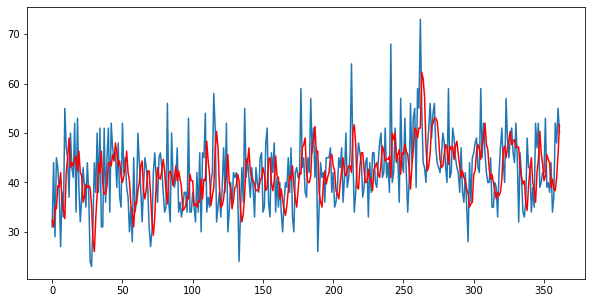

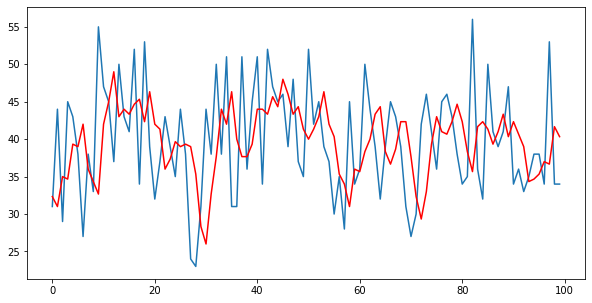

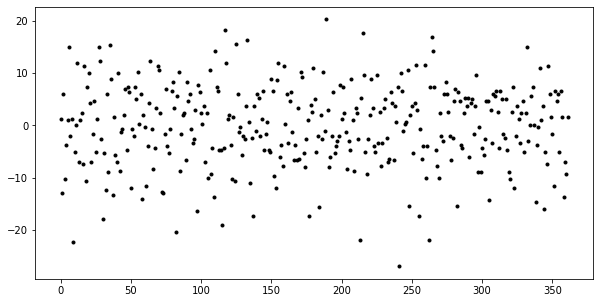

In [41]:
# Creating a simple model to predict next value using the mean of the past 3 values

from sklearn.metrics import mean_squared_error

X = series.values
window = 3
history = [X[i] for i in range(window)]
test = [X[i] for i in range(window, len(X))]
predictions = list()
# walk forward over time steps in test
for t in range(len(test)):
  length = len(history)
  yhat = np.mean([history[i] for i in range(length-window,length)])
  obs = test[t]
  predictions.append(yhat)
  history.append(obs)
  # print('predicted=%f, expected=%f' % (yhat, obs))
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()
# zoom plot
plt.plot(test[:100])
plt.plot(predictions[:100], color='red')
plt.show()
# Error component plot
error = np.array(predictions) - np.array(test)
plt.plot(error, 'k.')
plt.show()

To check if the error component is a white noise:

Mean = 0?
Mean: -0.10957642725598513
Does the variance change over time?

400.3693575864959

Do values correlate with lag values?


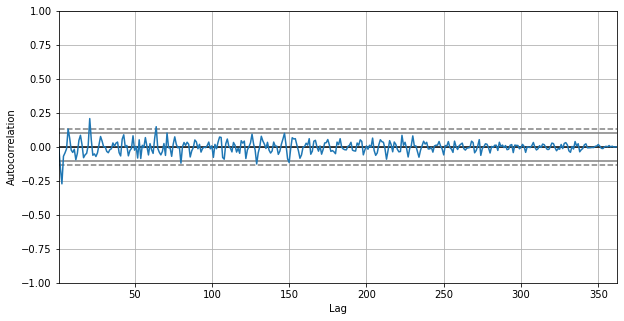

In [42]:
print('To check if the error component is a white noise:\n')

print('Mean = 0?\nMean:',np.mean(error))

# Needs to be validated ---------> Something is wrong
# To do so we will partition the error component into k equal folds, calcualte the variance for each fold
# The result will be a series of k values, we subtract the variance of the error series as a whole,
#  we calculate the variance of this series and it should be close to zero
# But we then have to choose k wisely

# k = 12; 12 groups
variances = []
k = 12
group_sz = len(error) // k
for i in range(k):
  if i == k:
    variances.append(np.var(error[i*group_sz:]))
  variances.append(np.var(error[ i*group_sz : (i+1)*group_sz]))
print('Does the variance change over time?\n')
print(np.var(variances))

# Since most of the autocorrelation values are between the confidence levels then the autocorrelation is not significant
# 95 confidence level: bold line, 99 confidence level: dashed line
print('\nDo values correlate with lag values?')
autocorrelation_plot(error)
plt.show()

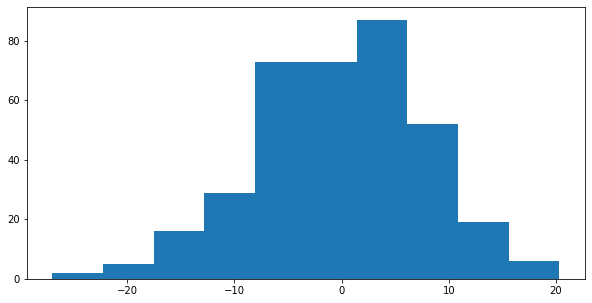

In [43]:
# error signal is nearly gausssian
plt.hist(error)
plt.show()

# Part 3 (Temporal Structure)

## Random Walks

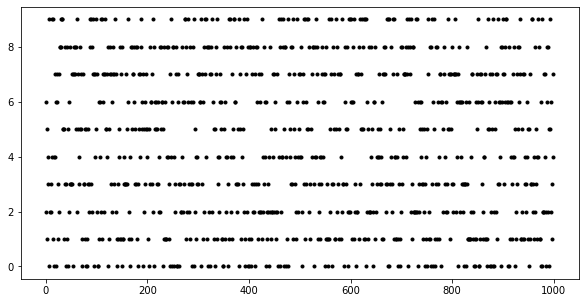

In [ ]:
# random gaussian series
series = pd.Series(np.random.randint(0,10,1000))

plt.plot(series,'k.')
plt.show()

In [ ]:
# Creating a series of size=10, of 1, -1
( np.round( np.random.random(10) ) * 2 ) - 1

array([ 1.,  1., -1.,  1.,  1.,  1., -1., -1., -1., -1.])

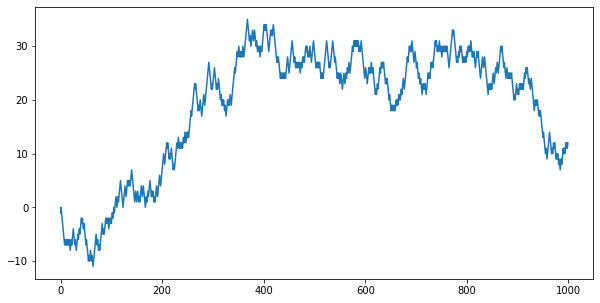

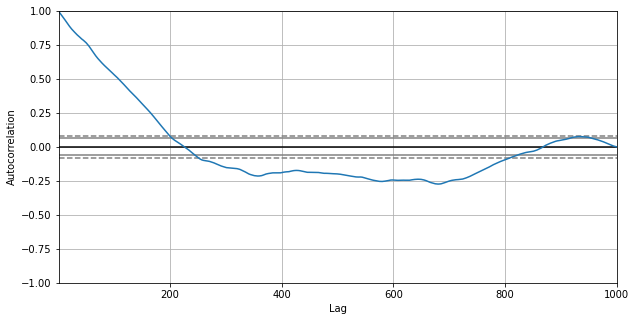

In [ ]:
# vectorize this later
# Creating a random walk that it's random component draws from either 0 or 1
np.random.seed(1)
random_walk = list()
random_walk.append(-1 if np.random.random() < 0.5 else 1)

for i in range(1, 1000):
  movement = -1 if np.random.random() < 0.5 else 1
  value = random_walk[i-1] + movement
  random_walk.append(value)

# Visualizing the data
plt.plot(random_walk)
plt.show()

# Autocorrelation function
autocorrelation_plot(random_walk)
plt.show()

## Random walk and stationary tests

In [ ]:
# The null hypothesis is that the series is non-stationary and since we failed to reject at all confidence levels provided
# then we can say that the data is non stationary
#  Augmented Dickey Fuller test (ADF Test)
from statsmodels.tsa.stattools import adfuller

result = adfuller(random_walk)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.830996
p-value: 0.365185
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


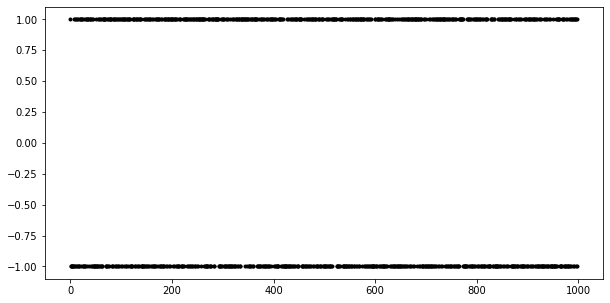

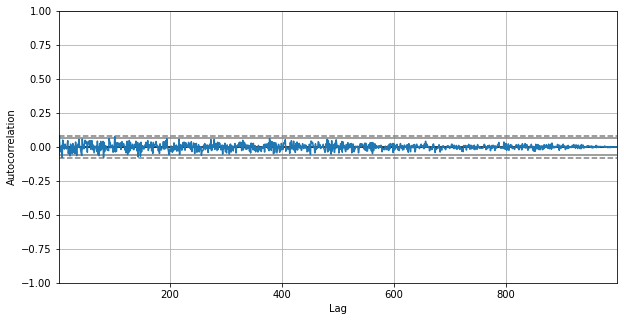

ADF Statistic: -21.113385
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


In [ ]:
# To make a random walk data stationary, we perform first differencing 
random_walk = np.array(random_walk)

diff = random_walk[1:] - random_walk[:-1]

# Visualizing the diff
plt.plot(diff,'k.')
plt.show()

# Autocorrelation function
autocorrelation_plot(diff)
plt.show()

# Since pvalue is close to zero we reject the null hypothesis that the data is not stationary
# Running an ADF test on the diff 
result = adfuller(diff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

In [ ]:
# Building a model that predicts the next value as the previous value
test, predictions = random_walk[1:], random_walk[:-1]

# Since the deviation from one timestep to another is either 1 or -1 therefore the rmse is 1
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Persistence RMSE: %.3f' % rmse)

Persistence RMSE: 1.000


## Seasonal Decomposition

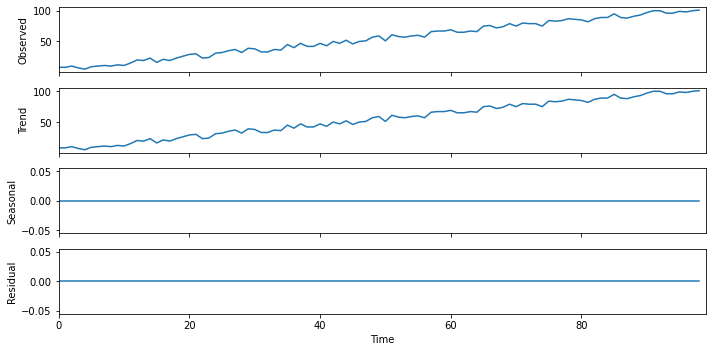

In [ ]:
# Using naive decomposition model we were not able to separate the noise added form the trend
from statsmodels.tsa.seasonal import seasonal_decompose

series = [i+np.random.randint(0,10) for i in range(1,100)]
result = seasonal_decompose(series, model='additive', freq=1)
result.plot()
plt.show()

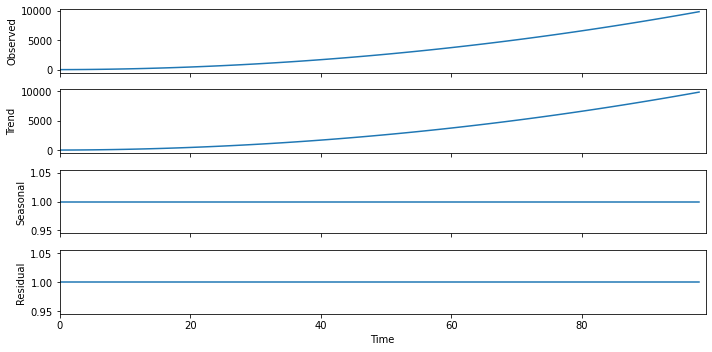

In [ ]:
# Multiplicative decomposition 
series = [i**2.0 for i in range(1,100)]
result = seasonal_decompose(series, model='multiplicative', freq=1)
result.plot()
plt.show()

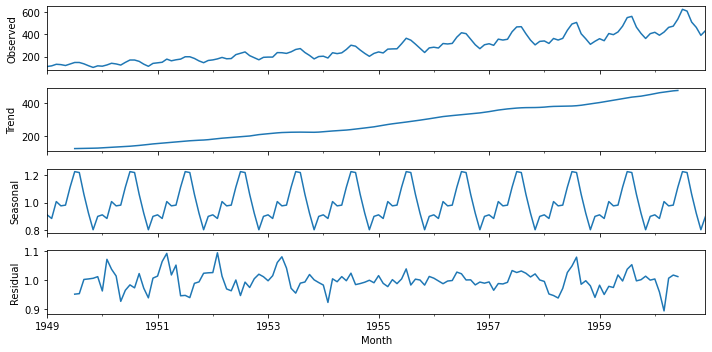

In [ ]:
series = pd.read_csv('/content/drive/MyDrive/ANONYMOUS MORHF/Cycle 1 (Traditional TS)/Hamamsy/AirPassengers.csv'
, header=0, index_col=0, parse_dates=True, squeeze=True
)
result = seasonal_decompose(series, model='multiplicative')
result.plot()
plt.show()

## De-trending

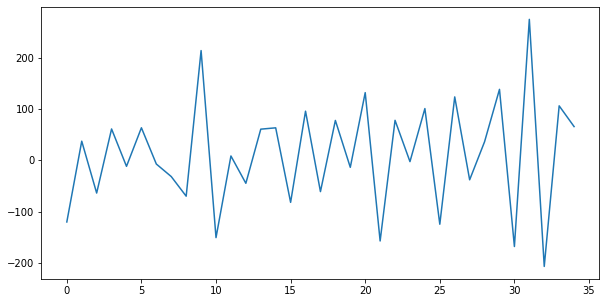

In [ ]:
# Beware of substracting two series as the substraction is done using the index
# Detrending by differencing
def parser(x):
  return datetime.strptime('190'+x, '%Y-%m')

series = pd.read_csv('/content/drive/MyDrive/ANONYMOUS MORHF/Cycle 1 (Traditional TS)/Hamamsy/shampoo_sales.csv'
, header=0, index_col=0, parse_dates=True, squeeze=True, date_parser=parser
)

diff = series[1:].values - series[:-1].values

plt.plot(diff)
plt.show()

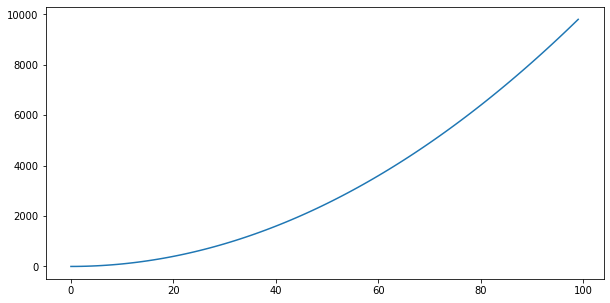

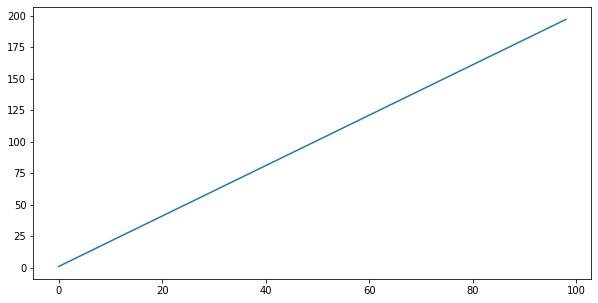

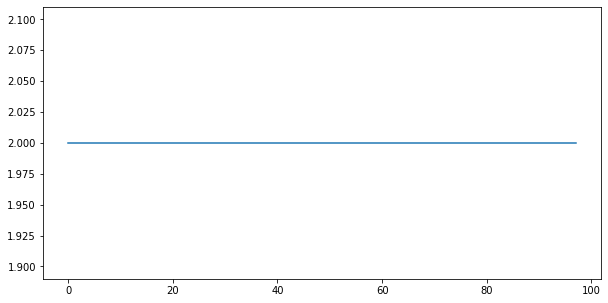

In [ ]:
# To test the second level differencing on quadratic trend
arr = np.array([i**2 for i in range(100)])

diff1 = arr[1:] - arr[:-1]
diff2 = diff1[1:] - diff1[:-1]

plt.plot(arr)
plt.show()

plt.plot(diff1)
plt.show()

plt.plot(diff2)
plt.show()

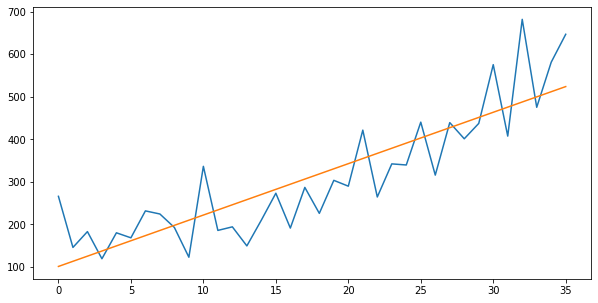

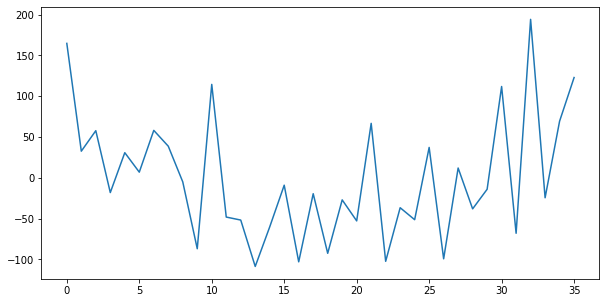

In [ ]:
# De-trending by fitting a linear model

from sklearn.linear_model import LinearRegression
X = np.arange(len(series)).reshape((-1,1))
y = series.values

model = LinearRegression()
model.fit(X, y)

# calculate trend
trend = model.predict(X)

# plot trend
plt.plot(y)
plt.plot(trend)
plt.show()

# detrend
detrended = y - trend

# plot detrended
plt.plot(detrended)
plt.show()

## Season Adjusting

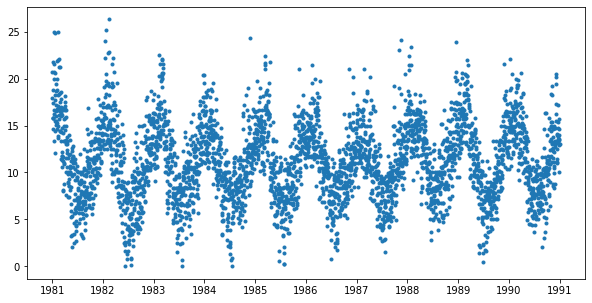

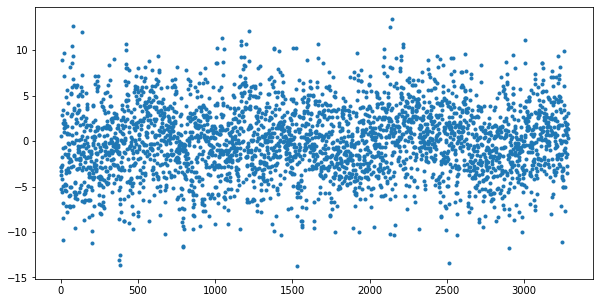

In [ ]:
# Seasonal Adjusting (Detrending), this does not account for leap years.
def differencing(series,period):
  return series.values[period:] - series.values[:-period]

series = pd.read_csv('/content/drive/MyDrive/ANONYMOUS MORHF/Cycle 1 (Traditional TS)/Hamamsy/daily-minimum-temperatures.csv', header=0, index_col=0,
parse_dates=True, squeeze=True, skipfooter=2, engine='python')
series = series.apply(rem_chars)

period = 365
diff = differencing(series,period)

# plot detrended
plt.plot(series,'.')
plt.show()

plt.plot(diff,'.')
plt.show()

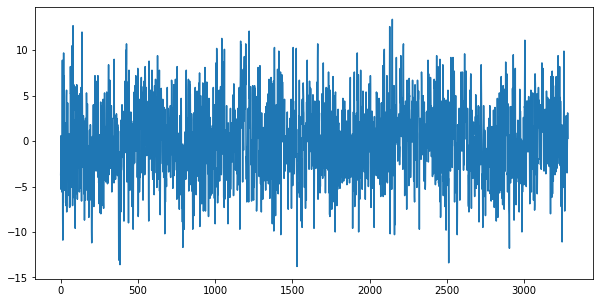

In [ ]:
# One thing we can do is to adjust today's temp by the mean of the same month last year 
days_in_year = 365
for i in range(days_in_year, len(X)):
  month_str = str(series.index[i].year-1)+'-'+str(series.index[i].month)
  month_mean_last_year = series[month_str].mean()
  value = X[i] - month_mean_last_year
  diff.append(value)
plt.plot(diff)
plt.show()

In [ ]:
## Incorrect
# month_year_lambda = lambda index  : str(index.year-1)+'-'+str(index.month) 
# month_mean = lambda month_index   : series[month_index].mean()

# months = series['1982-01-01':].index.map(month_year_lambda)
# last_year_mean = months.map(month_mean)

# series_season_adj = series['1982-01-01':].values - last_year_mean

# plt.plot(series_season_adj)
# plt.show()

In [ ]:
# Fit a polynomial to model the seasonality 

X = np.mod(np.arange(len(series)) , 365)
y = series.values

degree = 4

coef = np.polyfit(X, y, degree)
print('Coefficients: %s' % coef)

Coefficients: [-1.17308000e-08  9.30253946e-06 -2.15977594e-03  1.19147966e-01
  1.38980178e+01]


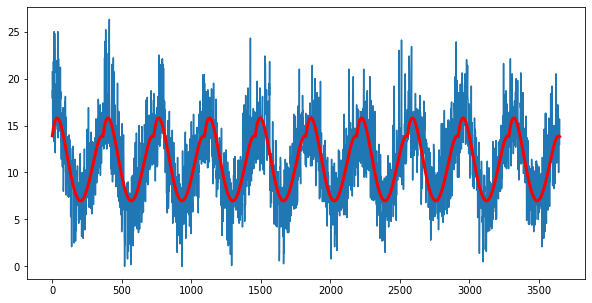

In [ ]:
curve = list()

curve = coef[-1]  
for d in range(degree):
  curve += X**(degree-d) * coef[d]

# plot curve over original data
plt.plot(series.values)
plt.plot(curve, color='red', linewidth=3)
plt.show()

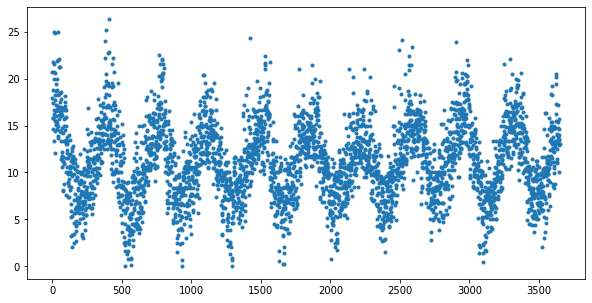

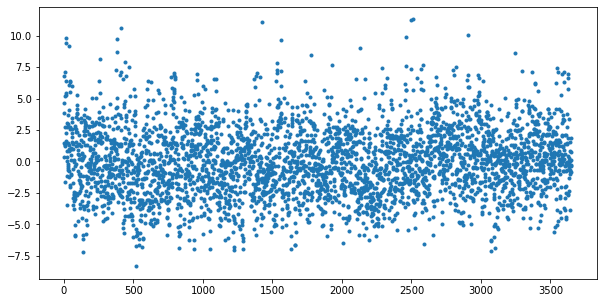

In [ ]:
# Seasonal Adjusting
diff = y - curve

plt.plot(y, '.')
plt.show()

plt.plot(diff, '.')
plt.show()

# Part 4 (Model's Evaluation)

## Backtesting (Sunspots dataset)

Observations: 3265
Training Observations: 2154
Testing Observations: 1111



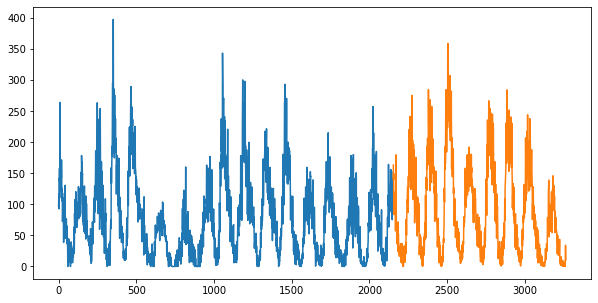

In [ ]:
series = pd.read_csv('/content/drive/MyDrive/ANONYMOUS MORHF/Cycle 1 (Traditional TS)/Hamamsy/Sunspots.csv'
, header=0, index_col=1, parse_dates=True, squeeze=True
)

series = series['Monthly Mean Total Sunspot Number']
X = series.values

train_size = int(len(X) * 0.66)
train, test = X[:train_size], X[train_size:]

print('Observations: %d' % (len(X)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))
print('')


plt.plot(train)
plt.plot([None for i in train] + [x for x in test])
plt.show()

Observations: 1306
Training Observations: 653
Testing Observations: 653

Observations: 1959
Training Observations: 1306
Testing Observations: 653

Observations: 2612
Training Observations: 1959
Testing Observations: 653

Observations: 3265
Training Observations: 2612
Testing Observations: 653



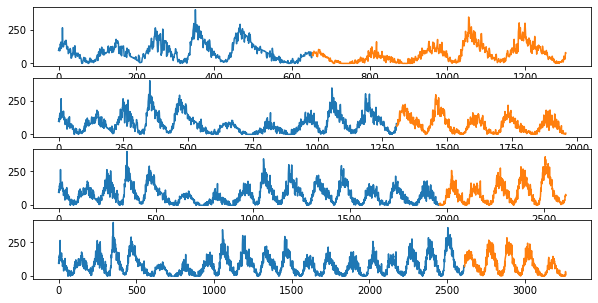

In [ ]:
# Multiple Train-Test Splits
from sklearn.model_selection import TimeSeriesSplit

n_split = 4
splits = TimeSeriesSplit(n_splits=n_split)
plt.figure(1)
index = 1

for train_index, test_index in splits.split(X):
  train = X[train_index]
  test = X[test_index]
  print('Observations: %d' % (len(train) + len(test)))
  print('Training Observations: %d' % (len(train)))
  print('Testing Observations: %d' % (len(test)))
  print('')
  plt.subplot(n_split*100+10 + index) # 3 plots, first col, index row 
  plt.plot(train)
  plt.plot([None for i in train] + [x for x in test])
  index += 1
plt.show()

In [ ]:
# walk forward evaluation model for time series data
n_train = 500
n_records = len(X)
test_size = 1 # My idea

for i in range(n_train, n_records,test_size):
  train, test = X[0:i], X[i:i+test_size]
  print('train=%d, test=%d' % (len(train), len(test)))
  if i == 510:
    break

train=500, test=1
train=501, test=1
train=502, test=1
train=503, test=1
train=504, test=1
train=505, test=1
train=506, test=1
train=507, test=1
train=508, test=1
train=509, test=1
train=510, test=1


## Persistance Model

In [ ]:
parser = lambda x: datetime.strptime('190'+x, '%Y-%m')

series = pd.read_csv('/content/drive/MyDrive/ANONYMOUS MORHF/Cycle 1 (Traditional TS)/Hamamsy/shampoo_sales.csv', header=0, index_col=0, parse_dates=True,
squeeze=True, date_parser=parser)

136.76131884905664 



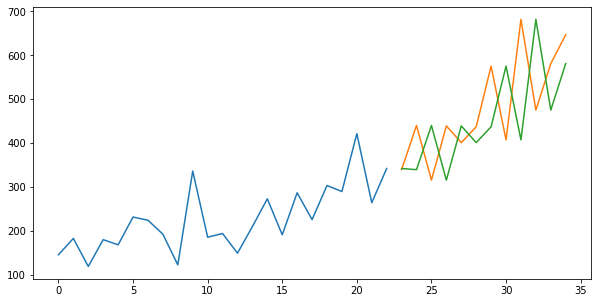

In [ ]:
from sklearn.metrics import mean_squared_error
# X and Y
values = pd.DataFrame(series.values)
df = pd.concat([values.shift(1),values], axis =1)[1:]
df.columns = ['t','t+1']

# Train-Test Split
X = df.values
train_size = int(len(X) * 0.66)
train, test = X[:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

print(np.sqrt(mean_squared_error(test_X, test_y)),'\n')

# plot predictions and expected results
plt.plot(train_y)
plt.plot([None for i in train_y] + [x for x in test_y])
plt.plot([None for i in train_y] + [x for x in test_X])
plt.show()

## Residual Forecast Errors

9.15238378960684 



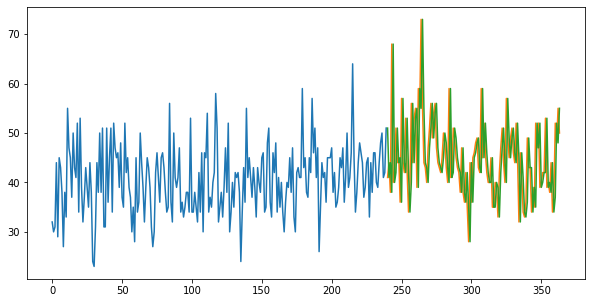

In [ ]:
series = pd.read_csv('/content/drive/MyDrive/ANONYMOUS MORHF/Cycle 1 (Traditional TS)/Hamamsy/daily-total-female-births.csv', header=0, index_col=0, parse_dates=True,
squeeze=True)

values = pd.DataFrame(series.values)
df = pd.concat([values.shift(1),values], axis =1)[1:]
df.columns = ['t','t+1']

# Train-Test Split
X = df.values
train_size = int(len(X) * 0.66)
train, test = X[:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

print(np.sqrt(mean_squared_error(test_X, test_y)),'\n')

# plot predictions and expected results
plt.plot(train_y)
plt.plot([None for i in train_y] + [x for x in test_y])
plt.plot([None for i in train_y] + [x for x in test_X])
plt.show()

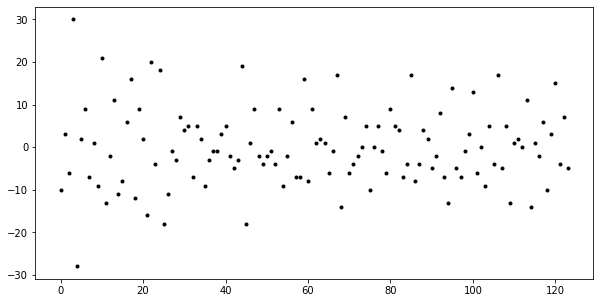

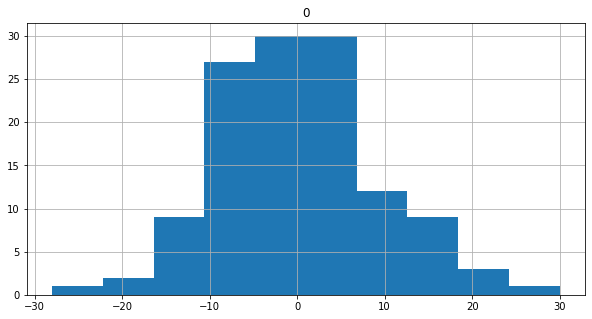

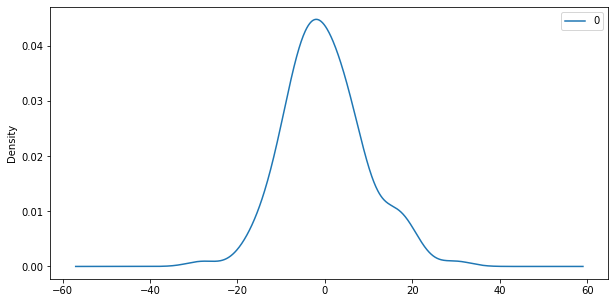

In [ ]:
# Plotting the residual
residuals = pd.DataFrame(test_y-test_X)
plt.plot(residuals,'k.') # Residual plot looks random
plt.show()

# Summarising the residual
residuals.describe()

# residuals distribution
residuals.hist()
plt.show()

# kde plot
residuals.plot(kind='kde')
plt.show()

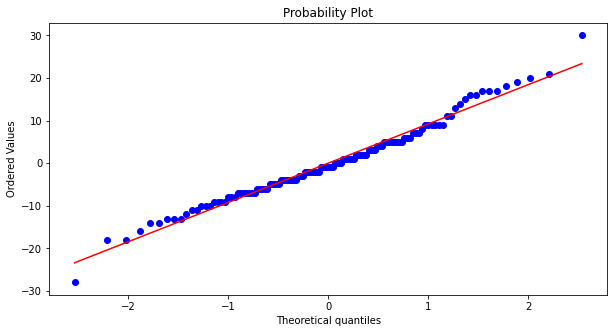

In [ ]:
# Checking Normality of residuals to validate the assumptions made for the model
import pylab 
import scipy.stats as stats

measurements = residuals.values.squeeze() # Uses 1d array
stats.probplot(measurements, dist="norm", plot=pylab)
pylab.show()

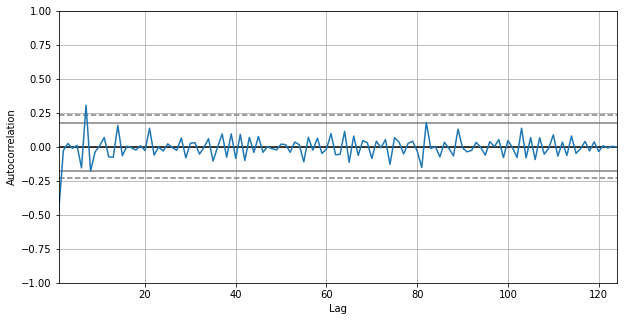

In [ ]:
# Residual Autocorrelation Plot
# Most auto correlation scores are below the threshold of significance
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(residuals)
plt.show()

In [ ]:
# To get the auto-correlation at all lags 
def df_autocorr(df):
    """Compute full-sample column-wise autocorrelation for a DataFrame."""
    auto_corr = []
    for lag in range(1,len(df)-1):
      auto_corr.append(df.apply(lambda col: col.autocorr(lag), axis=0)[0])

    return auto_corr


auto_corr_arr = df_autocorr(residuals)

# Part 5 (Forecast models)

## Integrated Part of ARIMA

In [ ]:
# We can iteratively perform unit root test to find the optimal d for the ARIMA model
# The code is not completed
from statsmodels.tsa.stattools import adfuller
series = pd.read_csv('/content/drive/MyDrive/ANONYMOUS MORHF/Cycle 1 (Traditional TS)/Hamamsy/AirPassengers.csv'
, header=0, index_col=0, parse_dates=True, squeeze=True
)

def d_param_ARIMA(series, alpha=0.05):
  """
  Returns d: which is the number of times differencing has been done until the p-val of ADF test was significant
  """
  p_val = 1
  series_diff = series.values
  d = 0
  while p_val >= alpha:
    p_val = adfuller(series_diff)[1]
    series_diff = series_diff[1:] - series_diff[:-1]
    d+=1

  return p_val,d

d_param_ARIMA(series)

(2.7328918500142026e-29, 3)

## AR

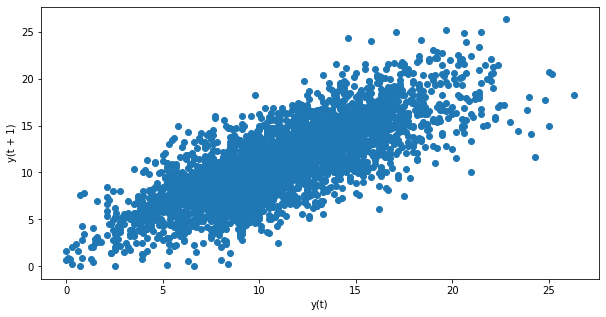

In [ ]:
# Lag plot is simply the scatterplot between current values and lag_1 values
from pandas.plotting import lag_plot

# To clean data from unexpected characters 
def rem_chars(str):
  return float(''.join([x for x in str if x.isnumeric() or x == '.']))

series = pd.read_csv('/content/drive/MyDrive/ANONYMOUS MORHF/Cycle 1 (Traditional TS)/Hamamsy/daily-minimum-temperatures.csv', header=0, index_col=0,
parse_dates=True, squeeze=True, skipfooter=2, engine='python')

# Cleaning the series permanently
series = series.apply(rem_chars)

lag_plot(series)
plt.show()

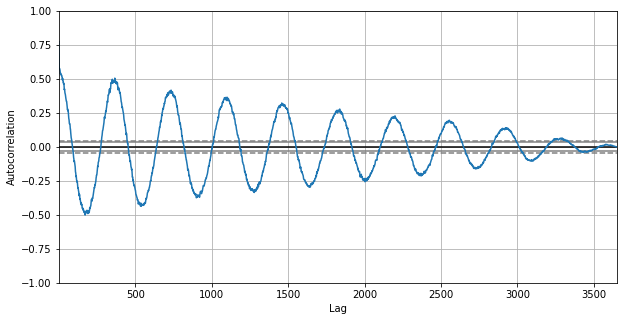

In [ ]:
# Autocorrelation plot 
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(series)
plt.show()

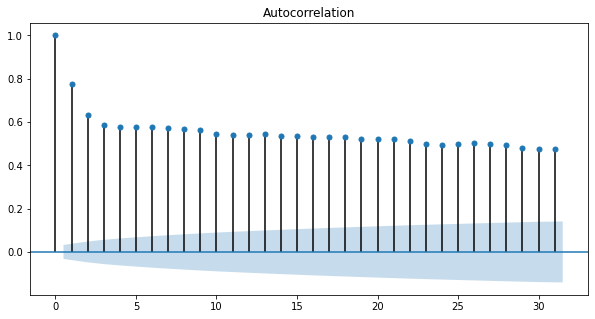

In [ ]:
# autocorrelation plot of time series (another version with lines)
from statsmodels.graphics.tsaplots import plot_acf

# We need to decide on the lags as the plot gets messy with larger lag values
plot_acf(series, lags=31)
plt.show()

Lag: 29
predicted=11.871275, expected=12.900000
predicted=13.053794, expected=14.600000
predicted=13.532591, expected=14.000000
predicted=13.243126, expected=13.600000
predicted=13.091438, expected=13.500000
predicted=13.146989, expected=15.700000
predicted=13.176153, expected=13.000000
Test RMSE: 1.225


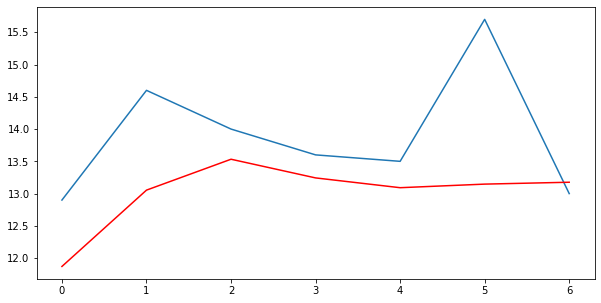

In [ ]:
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
# load dataset
X = series.values
train, test = X[1:len(X)-7], X[len(X)-7:]

# train autoregression
model = AR(train)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
# print('Coefficients: %s' % model_fit.params)

# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

for i in range(len(predictions)):
  print('predicted=%f, expected=%f' % (predictions[i], test[i]))

rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# plot results
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

predicted=11.871275, expected=12.900000
predicted=13.659297, expected=14.600000
predicted=14.349246, expected=14.000000
predicted=13.427454, expected=13.600000
predicted=13.374877, expected=13.500000
predicted=13.479991, expected=15.700000
predicted=14.765146, expected=13.000000
Test RMSE: 1.204


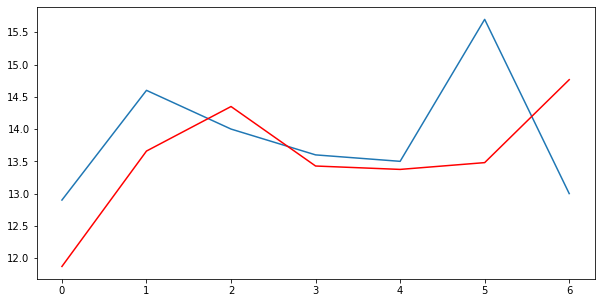

In [ ]:
#The AR model shortcoming is that it cannot take into account new values as they come,
# however we can still use the parameters learnt from earlier training. This, I presume, should hold valid for a short time.
# This how to do it 

from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error

X = series.values
train, test = X[1:len(X)-7], X[len(X)-7:]
# train autoregression
model = AR(train)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params
# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test)):
  length = len(history)
  lag = np.array(history[length-window : length])
  yhat = coef[0] + np.dot(coef[1:] , np.flip(lag) ) # Flip here as the coeffof the last val is the coef[1] 
  
  obs = test[t]
  predictions.append(yhat)
  history.append(obs)
  print('predicted=%f, expected=%f' % (yhat, obs))

rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [ ]:
np.flip([1,2,3,4])

array([4, 3, 2, 1])

## MA

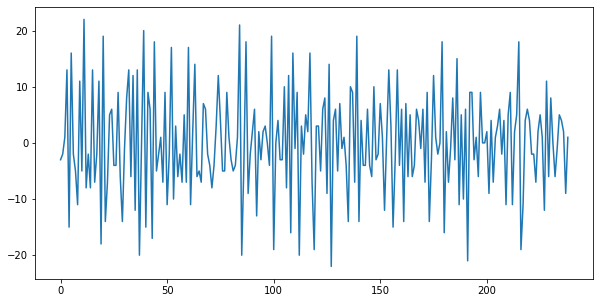

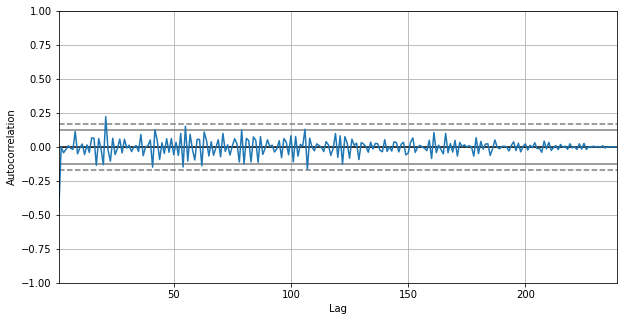

Lag=15, Coef=[ 0.10120699 -0.84940615 -0.77783609 -0.73345006 -0.68902061 -0.59270551
 -0.5376728  -0.42553356 -0.24861246 -0.19972102 -0.15954013 -0.11045476
 -0.14045572 -0.13299964 -0.12515801 -0.03615774]


In [ ]:
# We will build an auto-regressive model on the residuals of the persistance model
from statsmodels.tsa.ar_model import AR
from pandas.plotting import autocorrelation_plot

series = pd.read_csv('/content/drive/MyDrive/ANONYMOUS MORHF/Cycle 1 (Traditional TS)/Hamamsy/daily-total-female-births.csv', header=0, index_col=0, parse_dates=True,
squeeze=True)

# create lagged dataset
values = pd.DataFrame(series.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']

# split into train and test sets
X = dataframe.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

# persistence model on training set
pred_train = train_X

train_resid = train_y - train_X

# Visualizing the residuals
plt.plot(train_resid)
plt.show()

autocorrelation_plot(train_resid)
plt.show()

# Modelling the residuals
model = AR(train_resid)
model_fitted = model.fit()

window = model_fitted.k_ar
coef = model_fitted.params
print('Lag=%d, Coef=%s' % (window, coef))

Test RMSE: 7.499


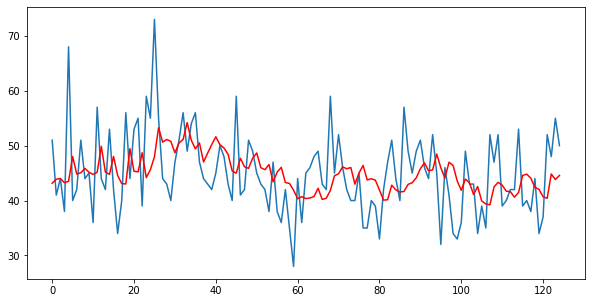

In [ ]:
# walk forward over time steps in test
history = train_resid[len(train_resid)-window:]
history = [history[i] for i in range(len(history))] # Listing teh array

predictions = list()
expected_error = list()

for t in range(len(test_y)):
  # persistence
  yhat = test_X[t]
  error = test_y[t] - yhat
  expected_error.append(error)

  # predict error
  length = len(history)
  lagged_err = np.array(history[length-window : length])
  pred_error = coef[0] + np.dot(coef[1:] , np.flip(lagged_err) ) # Flip here as the coeffof the last val is the coef[1] 

  # correct the prediction
  yhat = yhat + pred_error
  predictions.append(yhat)
  history.append(error)

# error
rmse = np.sqrt(mean_squared_error(test_y, predictions))
print('Test RMSE: %.3f' % rmse)
  
# plot predicted error
plt.plot(test_y)
plt.plot(predictions, color='red')
plt.show()

## ARIMA

> A linear regression model is constructed including the specified number and type of terms,
and the data is prepared by a degree of dierencing in order to make it stationary, i.e. to
remove trend and seasonal structures that negatively aect the regression model. A value of 0
can be used for a parameter, which indicates to not use that element of the model. This way,
the ARIMA model can be configured to perform the function of an ARMA model, and even a
simple AR, I, or MA model.

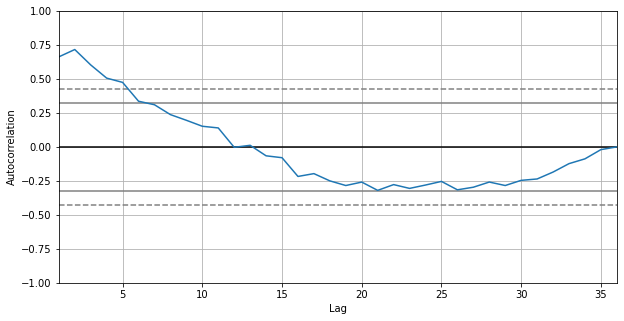

In [ ]:
from pandas.plotting import autocorrelation_plot

parser = lambda x: datetime.strptime('190'+x, '%Y-%m')

series = pd.read_csv('/content/drive/MyDrive/ANONYMOUS MORHF/Cycle 1 (Traditional TS)/Hamamsy/shampoo_sales.csv', header=0, index_col=0, parse_dates=True,
squeeze=True, date_parser=parser)

# The autocorrelation plot shows that the autocorrelation is significant till the 5th lag
# We can use this as 'p' for ARIMA
autocorrelation_plot(series)
plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                   35
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -196.170
Method:                       css-mle   S.D. of innovations             64.241
Date:                Sun, 08 Aug 2021   AIC                            406.340
Time:                        19:53:18   BIC                            417.227
Sample:                    02-01-1901   HQIC                           410.098
                         - 12-01-1903                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            12.0649      3.652      3.304      0.003       4.908      19.222
ar.L1.D.Sales    -1.1082      0.183     -6.063      0.000      -1.466      -0.750
ar.L2.D.Sales    -0.6203      0.282     

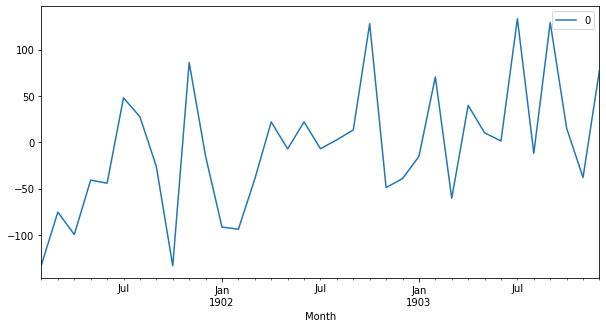

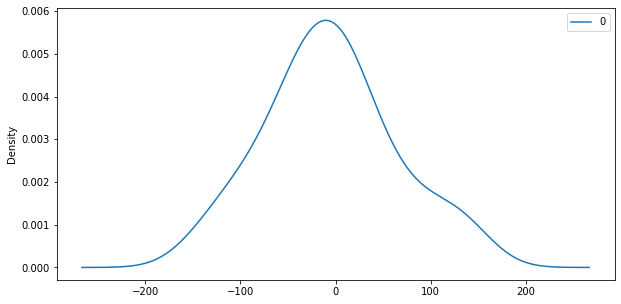

                0
count   35.000000
mean    -5.495223
std     68.132882
min   -133.296638
25%    -42.477902
50%     -7.186558
75%     24.748322
max    133.237947


In [ ]:
# Building the model itself
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(series, order=(5,1,0))
model_fit = model.fit(disp=0)

# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

Test RMSE: 81.918


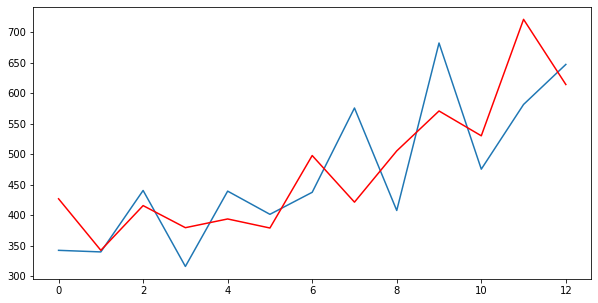

In [ ]:
# ARIMA model
from sklearn.metrics import mean_squared_error


X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

_ , d = d_param_ARIMA(series) # reduced RMSE to 81.9 from 83.4

# walk-forward validation
for t in range(len(test)):
  model = ARIMA(history, order=(5,d,0))
  model_fit = model.fit(disp=0)
  output = model_fit.forecast() 
  yhat = output[0]
  predictions.append(yhat)
  obs = test[t]
  history.append(obs)

# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

Test RMSE: 133.156


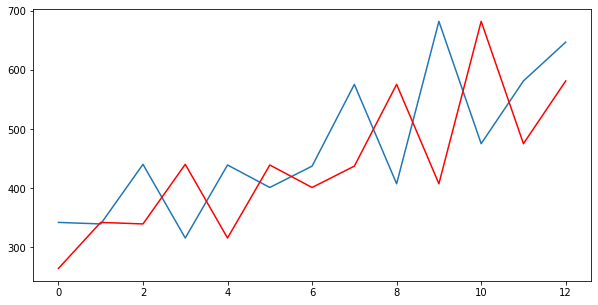

In [ ]:
# Comparing against persistance model
persis_pred = np.concatenate(([train[-1]], test))[:-1]  

# evaluate forecasts
persis_rmse = np.sqrt(mean_squared_error(test, persis_pred))
print('Test RMSE: %.3f' % persis_rmse)
# plot forecasts against actusis_rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(persis_pred, color='red')
plt.show()

In [ ]:
print('Persistance model RMSE: ', persis_rmse)
print('ARIMA model RMSE: ', rmse)

Persistance model RMSE:  133.15599296140772
ARIMA model RMSE:  81.9177757482596


## ACF & PACF

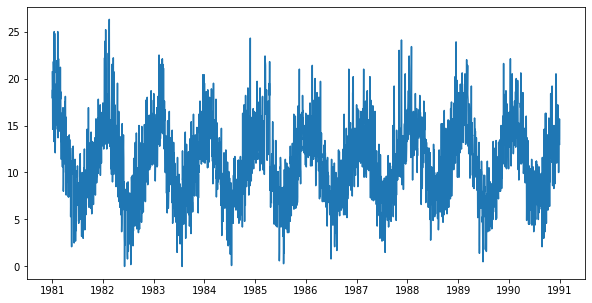

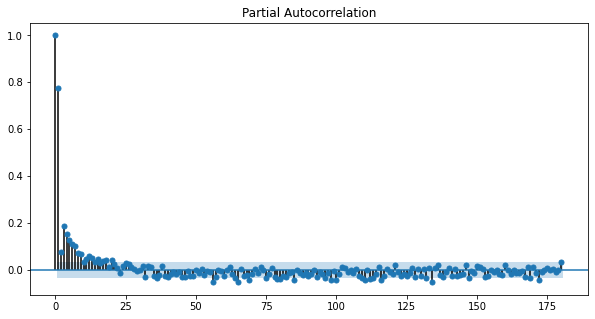

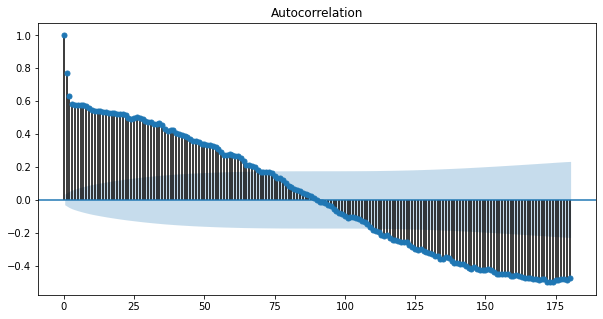

In [ ]:
# PACF
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
series = pd.read_csv('/content/drive/MyDrive/ANONYMOUS MORHF/Cycle 1 (Traditional TS)/Hamamsy/daily-minimum-temperatures.csv', header=0, index_col=0,
parse_dates=True, squeeze=True, skipfooter=2, engine='python')

# To clean data from unexpected characters 
def rem_chars(str):
  return float(''.join([x for x in str if x.isnumeric() or x == '.']))

# Cleaning the series permanently
series = series.apply(rem_chars)

plt.plot(series)
plt.show()

plot_pacf(series, lags=180)
plt.show()

plot_acf(series, lags=180)
plt.show()

In [ ]:
from statsmodels.tsa.stattools import pacf
pacf(series,nlags=5)

array([1.        , 0.77448019, 0.07699674, 0.18937821, 0.15207736,
       0.12986503])

In [ ]:
# Understand How PACF works, each time we calculate the PACF for a lag we build a linear regression model with that lag as x and the subsequent lags
# We take the coefficient of the specified lag only as the PACF value for that lag 
from sklearn import linear_model

nlags = 5

lag_1 = series.shift(1)
lag_2 = series.shift(2)
lag_3 = series.shift(3)
lag_4 = series.shift(4)
lag_5 = series.shift(5)

df = pd.concat([lag_1,lag_2,lag_3,lag_4,lag_5,series],axis=1).iloc[5:]
df.columns=['t-1','t-2','t-3','t-4','t-5','t']
y = df['t'].values

for i in range(1,nlags+1):
  X = df.iloc[:,0:i].values
  # Fitting a linear regressor
  regr = linear_model.LinearRegression()
  regr.fit(X,y)
  # The coefficients
  print('Coefficients: \n', regr.coef_)

Coefficients: 
 [0.77434411]
Coefficients: 
 [0.71511748 0.07647375]
Coefficients: 
 [ 0.70047452 -0.05994226  0.1906947 ]
Coefficients: 
 [ 0.67160945 -0.05088507  0.0847342   0.15116897]
Coefficients: 
 [ 0.65184243 -0.06186469  0.09125501  0.06352482  0.13038339]


## Grid Search

In [ ]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
  # prepare training dataset
  train_size = int(len(X) * 0.66)
  train, test = X[0:train_size], X[train_size:]
  history = [x for x in train]
  # make predictions
  predictions = list()
  for t in range(len(test)):
    model = ARIMA(history, order=arima_order)
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test[t])
  # calculate out-of-sample error
  rmse = np.sqrt(mean_squared_error(test, predictions))
  return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
  dataset = dataset.astype('float32')
  best_score, best_cfg = float("inf"), None
  for p in p_values:
    for d in d_values:
      for q in q_values:
        order = (p,d,q)
        try:
          rmse = evaluate_arima_model(dataset, order)
          if rmse < best_score:
            best_score, best_cfg = rmse, order
            print('ARIMA%s RMSE=%.3f' % (order,rmse))
        except:
          continue
  print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [ ]:
# Shampoo sales dataset
import warnings
warnings.filterwarnings("ignore")

parser = lambda x: datetime.strptime('190'+x, '%Y-%m')

series = pd.read_csv('/content/drive/MyDrive/ANONYMOUS MORHF/Cycle 1 (Traditional TS)/Hamamsy/shampoo_sales.csv', header=0, index_col=0, parse_dates=True,
squeeze=True, date_parser=parser)

# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=228.966
ARIMA(0, 0, 1) RMSE=195.308
ARIMA(0, 0, 2) RMSE=154.886
ARIMA(0, 1, 0) RMSE=134.176
ARIMA(0, 1, 1) RMSE=97.767
ARIMA(1, 1, 0) RMSE=84.388
ARIMA(1, 1, 1) RMSE=83.688
ARIMA(2, 1, 0) RMSE=75.432
ARIMA(4, 2, 1) RMSE=68.519
ARIMA(6, 1, 1) RMSE=66.258
Best ARIMA(6, 1, 1) RMSE=66.258


## Saving and Loading

In [46]:
# fit an AR model and manually save coefficients to file
from statsmodels.tsa.ar_model import AR

# create a difference transform of the dataset
def difference(dataset,d=1):
  return dataset[d:] - dataset[:-d]

# load dataset
series = pd.read_csv('/content/drive/MyDrive/ANONYMOUS MORHF/Cycle 1 (Traditional TS)/Hamamsy/daily-total-female-births.csv', header=0, index_col=0, parse_dates=True,
squeeze=True)
X = difference(series.values)

# fit model
window_size = 6
model = AR(X)
model_fit = model.fit(maxlag=window_size, disp=False)

# save coefficients
coef = model_fit.params
np.save('man_model.npy', coef)

# save lag
lag = X[-window_size:]
np.save('man_data.npy', lag)

# save the last ob
np.save('man_obs.npy', [series.values[-1]])

In [47]:
# load a coefficients and from file and make a manual prediction
def predict(coef, history,window_size):
  length = len(history)
  lag = np.array(history[length-window_size : length])
  yhat = coef[0] + + np.dot(coef[1:] , np.flip(lag) )
  return yhat

# load model
coef =    np.load('man_model.npy')
lag =     np.load('man_data.npy')
last_ob = np.load('man_obs.npy')

# make prediction
prediction = predict(coef, lag, window_size)

# transform prediction
yhat = prediction + last_ob[0]
print('Prediction: %f' % yhat)

Prediction: 46.755211


## Confidence Interval Of predictions

In [48]:
from statsmodels.tsa.arima_model import ARIMA

# split into train and test sets
X = series.values
X = X.astype('float32')
size = len(X) - 1
train, test = X[0:size], X[size:]

# fit an ARIMA model
model = ARIMA(train, order=(5,1,1))
model_fit = model.fit(disp=False)

# forecast
forecast, stderr, conf = model_fit.forecast(alpha=0.05)

# summarize forecast and confidence intervals
print('Expected: %.3f' % test[0])
print('Forecast: %.3f' % forecast)
print('Standard Error: %.3f' % stderr)
print('95%% Confidence Interval: %.3f to %.3f' % (conf[0][0], conf[0][1]))

Expected: 50.000
Forecast: 45.878
Standard Error: 6.996
95% Confidence Interval: 32.167 to 59.590


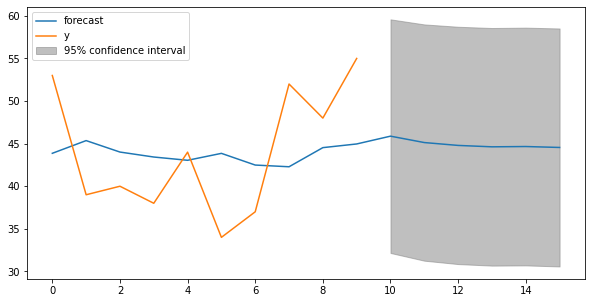

In [52]:
# plot some history and the forecast with confidence intervals
model_fit.plot_predict(len(train)-10, len(train)+5) #We predict values that we trained on and one value afterward
plt.legend(loc='upper left')
plt.show()